# COGS 118B Project

### By Miguel Garcia and Janina Schuhmacher


In [35]:
import sklearn.metrics as metrics
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import check_X_y
import warnings
warnings.filterwarnings("ignore")

In [36]:
#name the columns
colnames=['age', 'workclass',  'fnlwgt', 'education', 
          'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'capital-gain', 
          'capital-loss', 'hours-per-week', 'native-country', 'income']


# read data in df
df = pd.read_csv('adult.data', names=colnames, header=None)

In [37]:
# display df header
data_top = df.head()   
data_top

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Drop null values

In [38]:
df.shape #before dropping nulls

(32561, 15)

In [39]:
for i in colnames:   #ignores all null values
    df = df[(df[i] != ' ?')]

In [40]:
df.shape #after dropping nulls

(30162, 15)

### Keep income only from Americans since it represents most of the data and remove trailing white space

In [41]:
df['native-country'].value_counts()

 United-States                 27504
 Mexico                          610
 Philippines                     188
 Germany                         128
 Puerto-Rico                     109
 Canada                          107
 India                           100
 El-Salvador                     100
 Cuba                             92
 England                          86
 Jamaica                          80
 South                            71
 Italy                            68
 China                            68
 Dominican-Republic               67
 Vietnam                          64
 Guatemala                        63
 Japan                            59
 Columbia                         56
 Poland                           56
 Haiti                            42
 Iran                             42
 Taiwan                           42
 Portugal                         34
 Nicaragua                        33
 Peru                             30
 Greece                           29
 

In [42]:
df = df[(df['native-country'] == ' United-States')]
df = df.reset_index()

In [43]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [44]:
df.shape

(27504, 16)

### Visualize the distribution of the categorical features

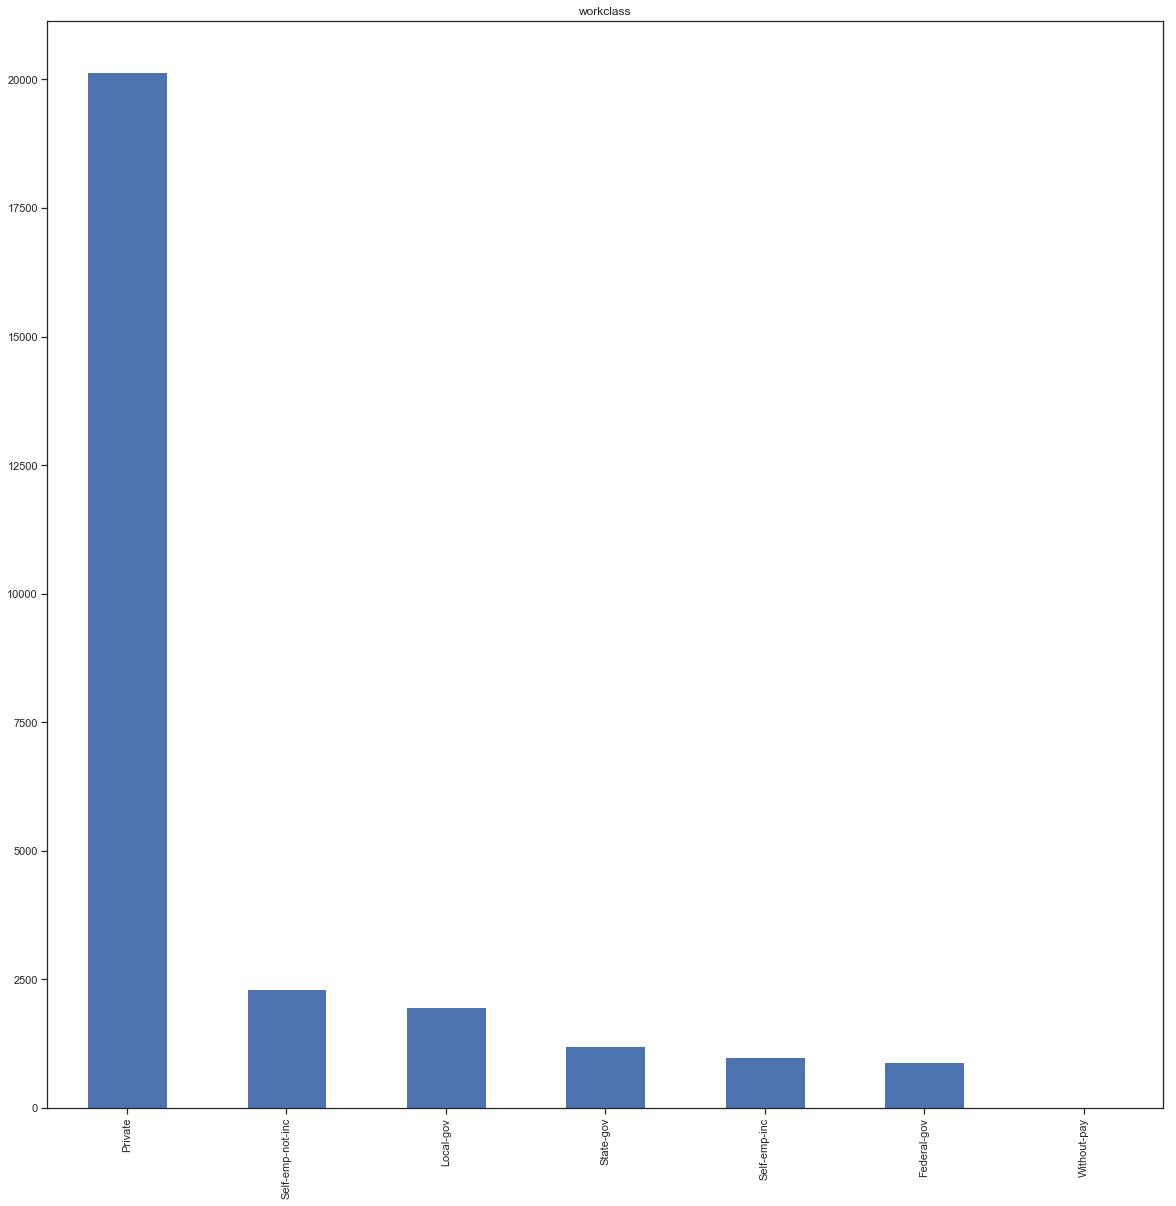

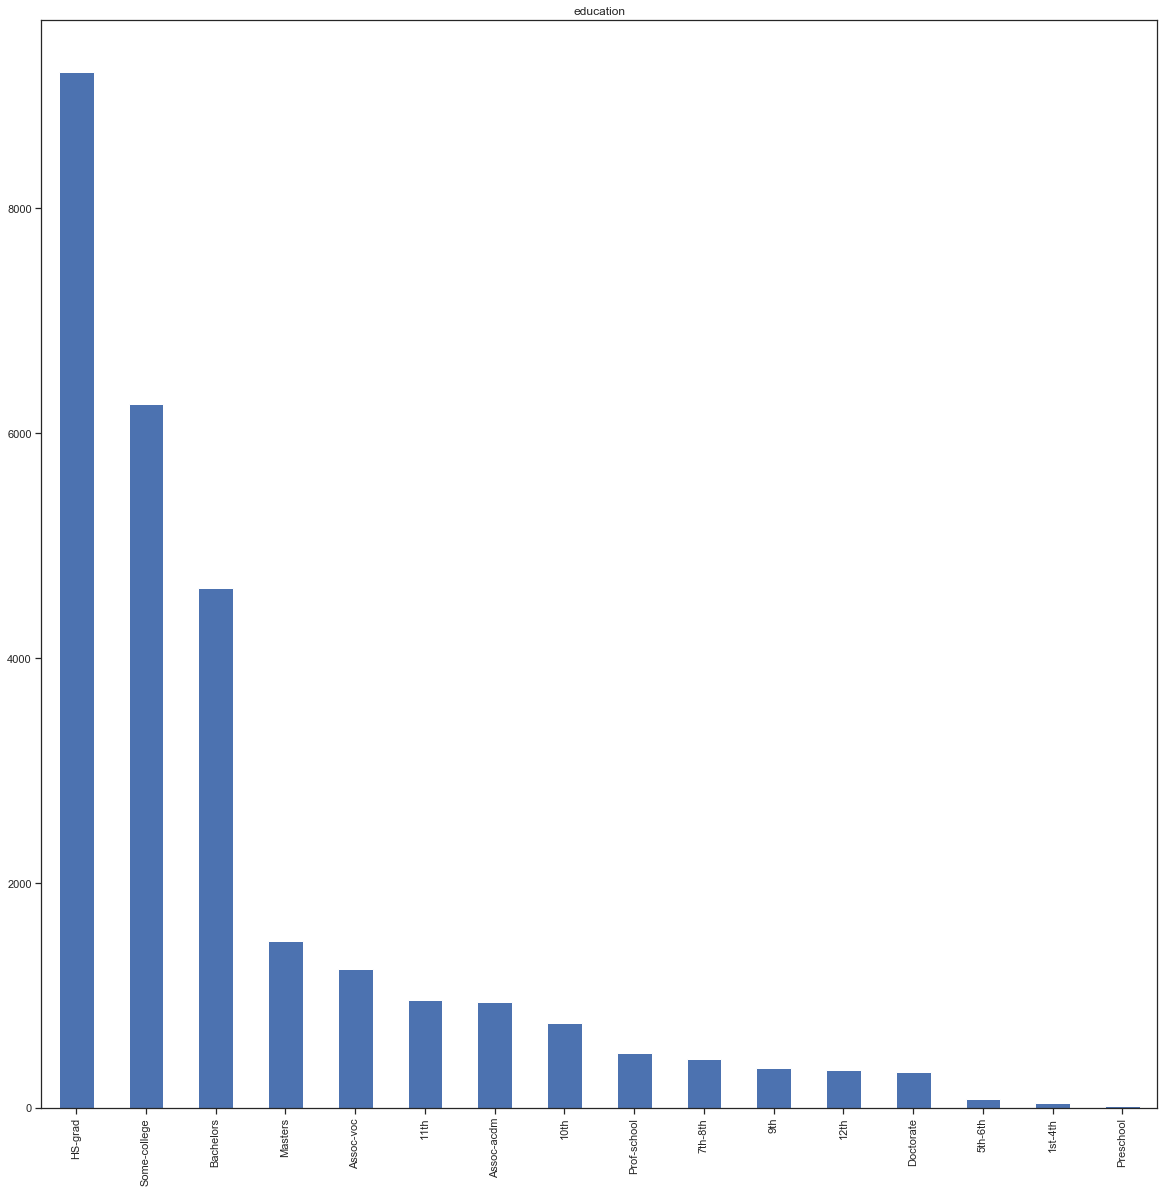

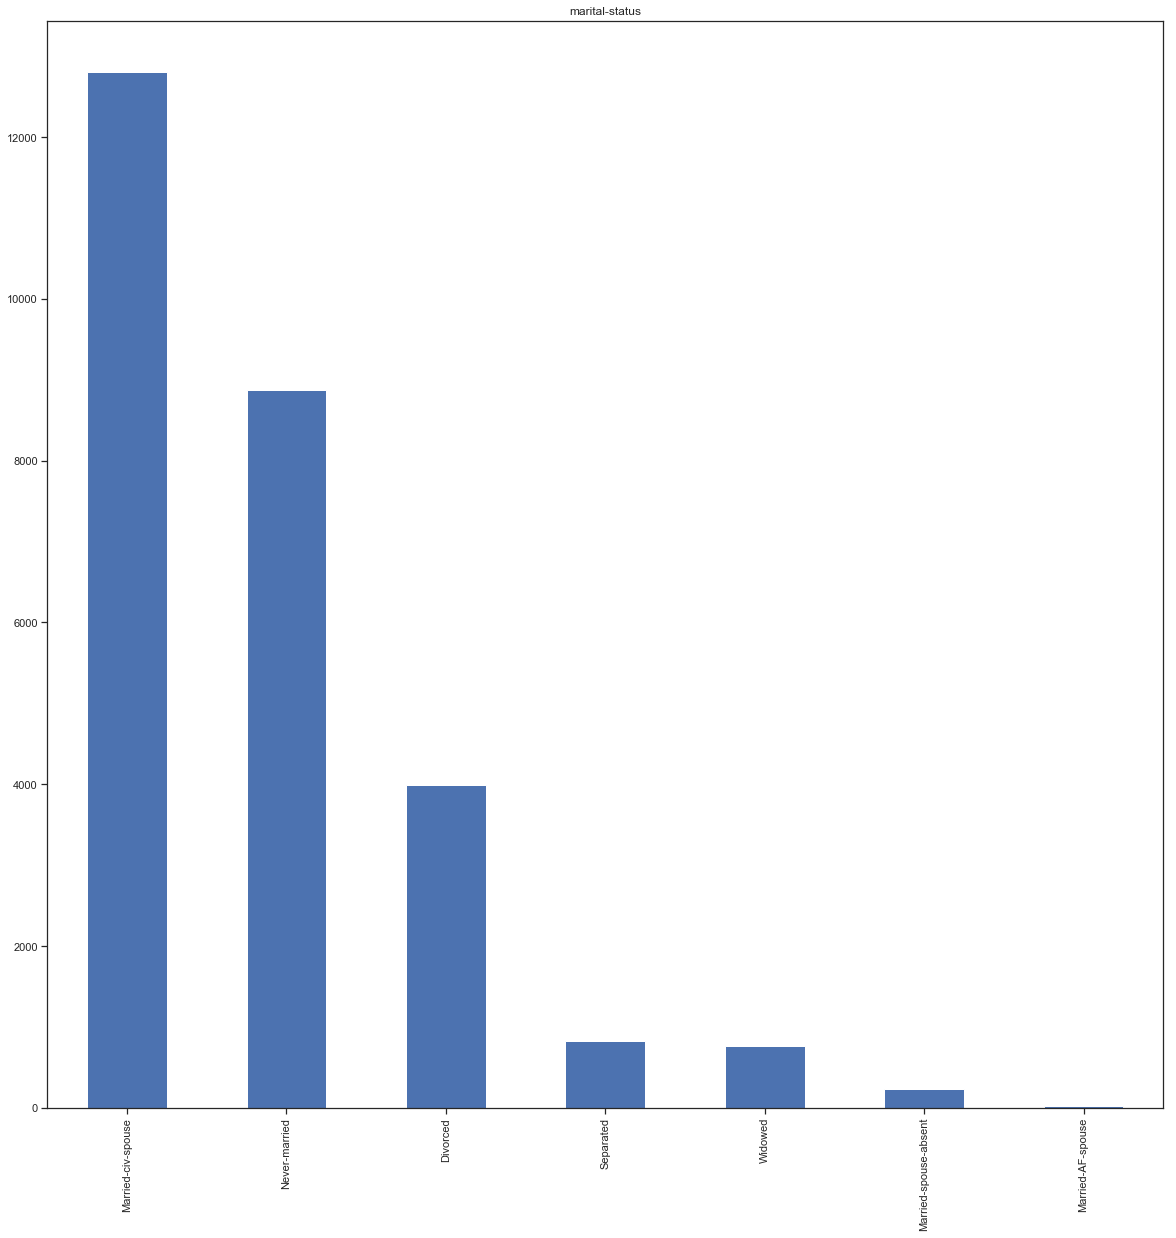

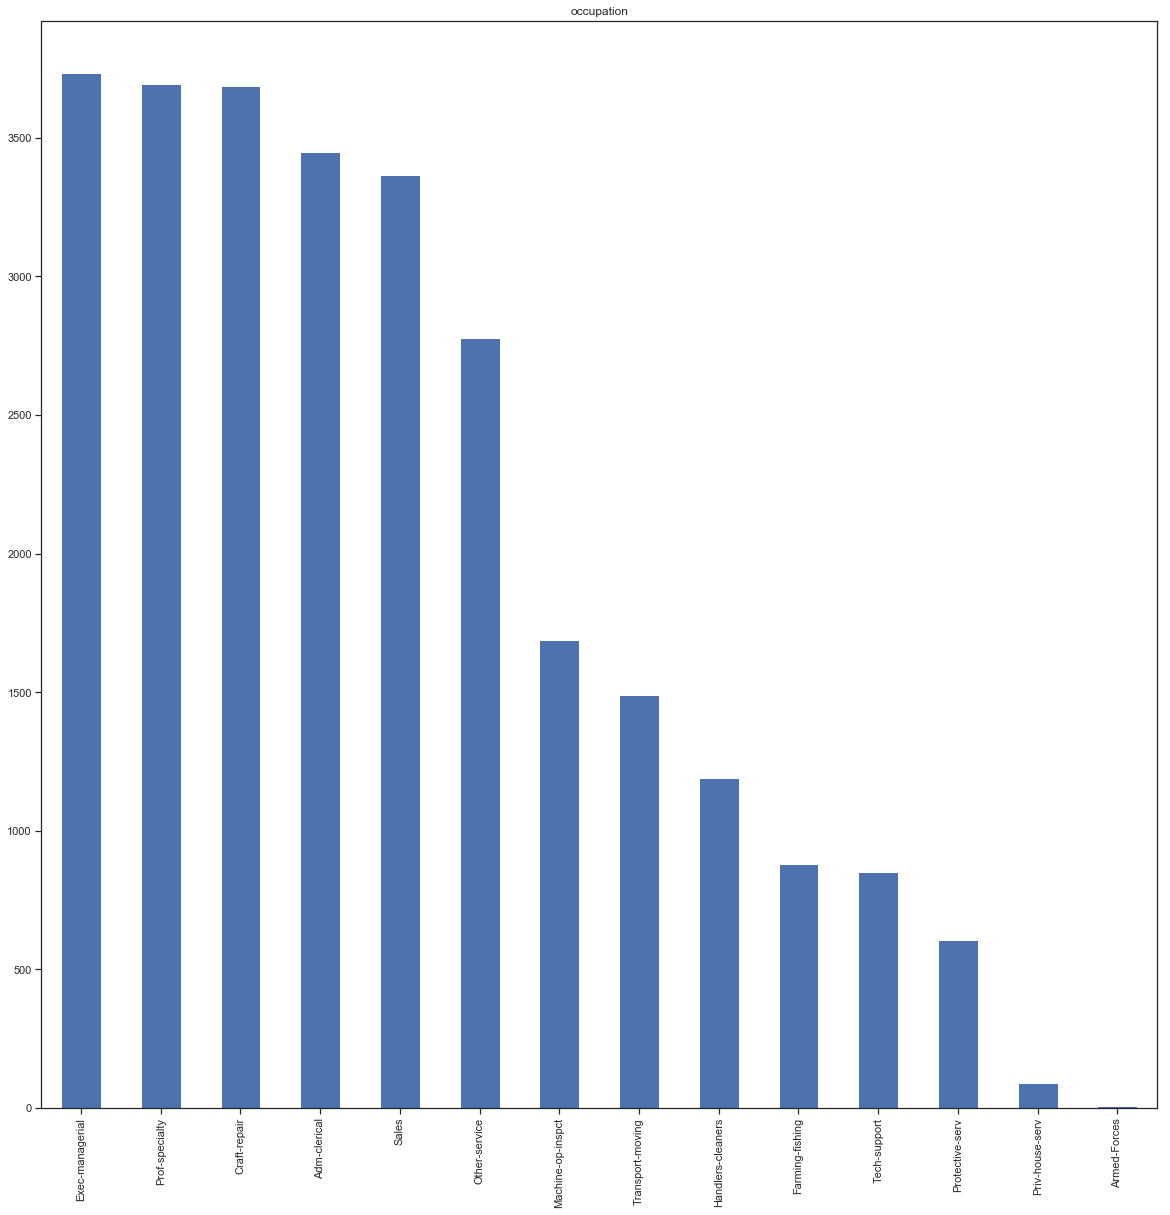

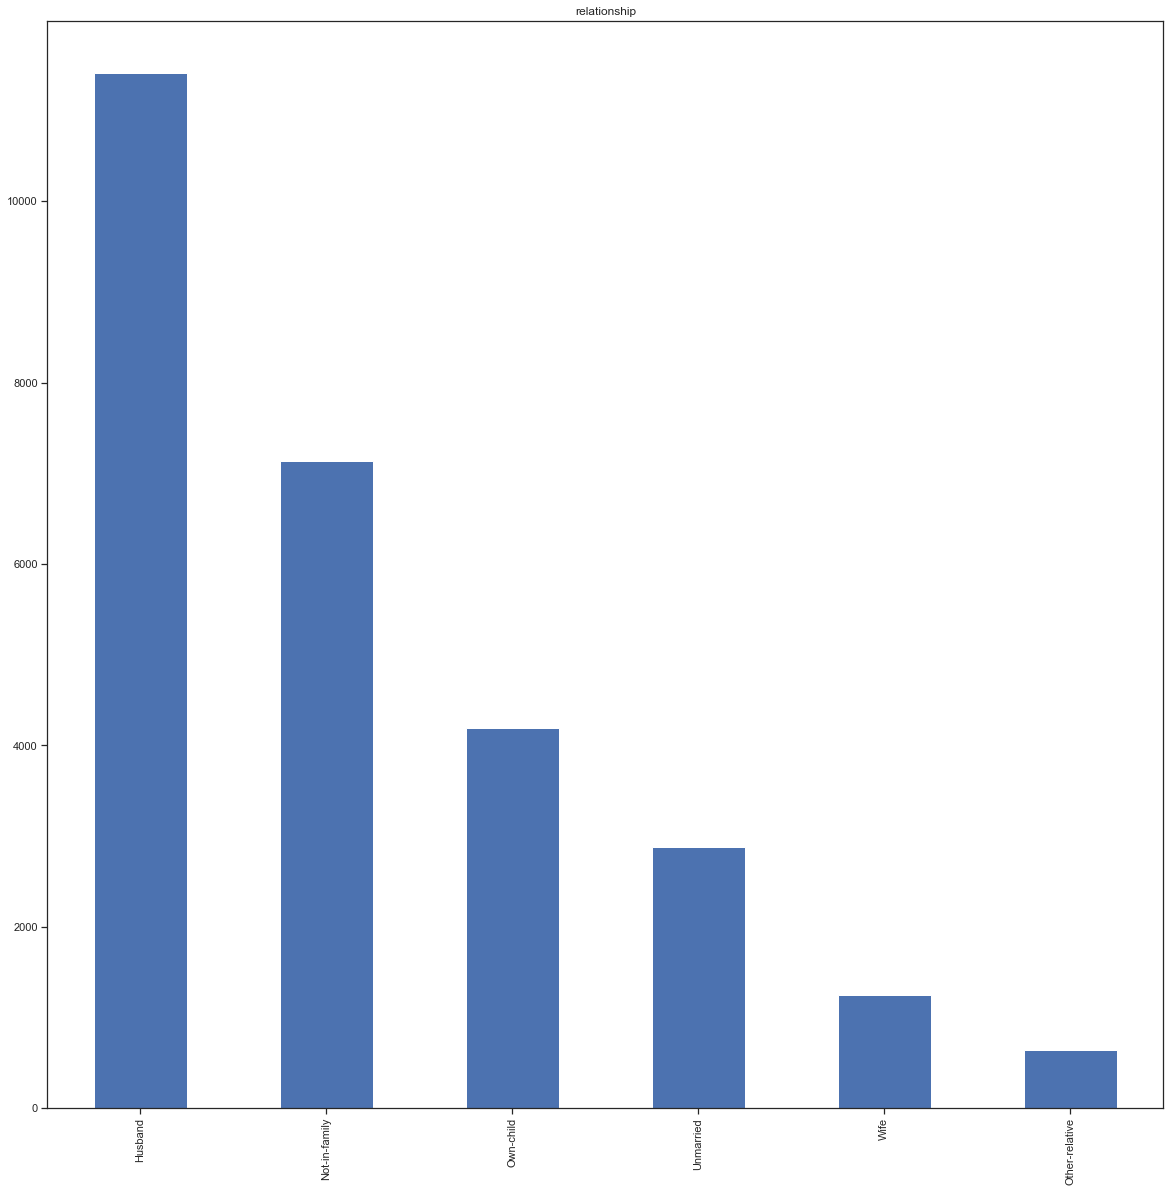

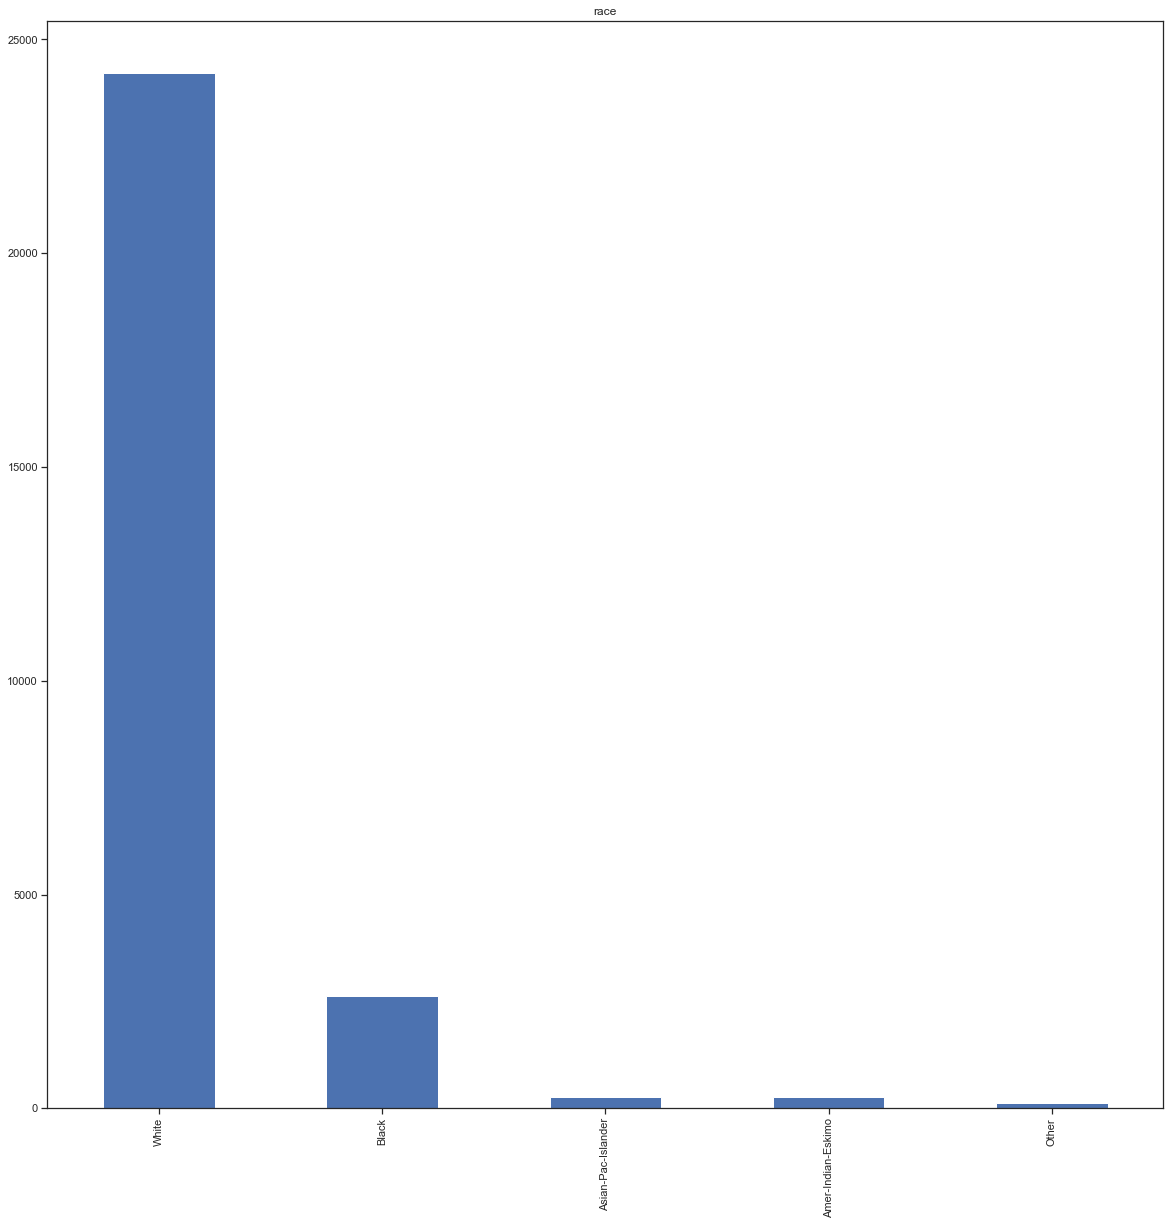

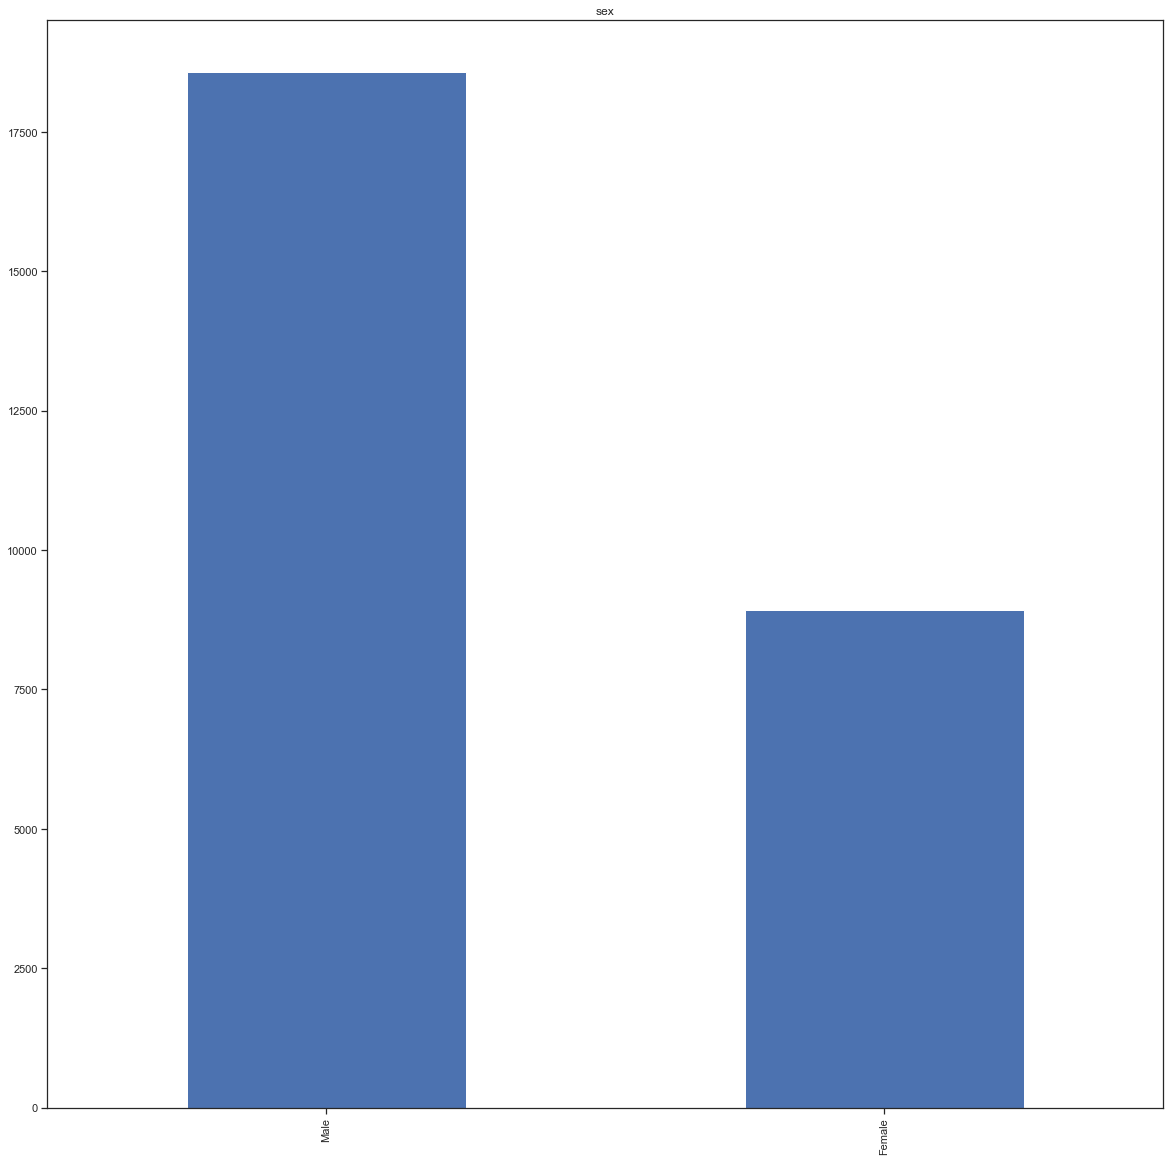

In [45]:
# plotting the frequency of the values

string_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

for col in string_columns: 
    fig, ax = plt.subplots()
    df[col].value_counts().plot(ax=ax, kind='bar', title = col)

## Visualize the continuous feautures

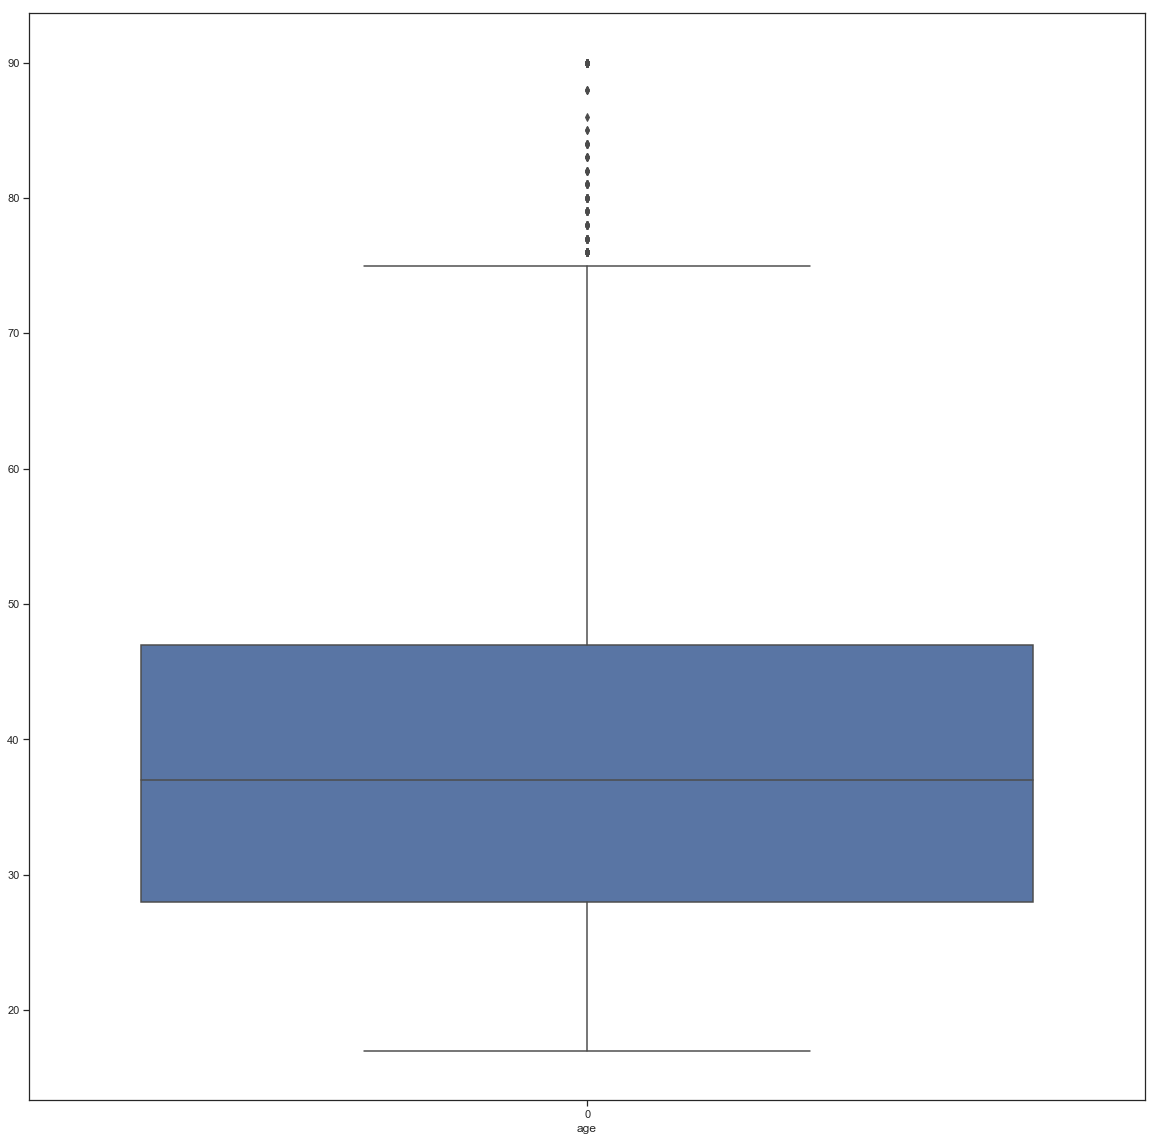

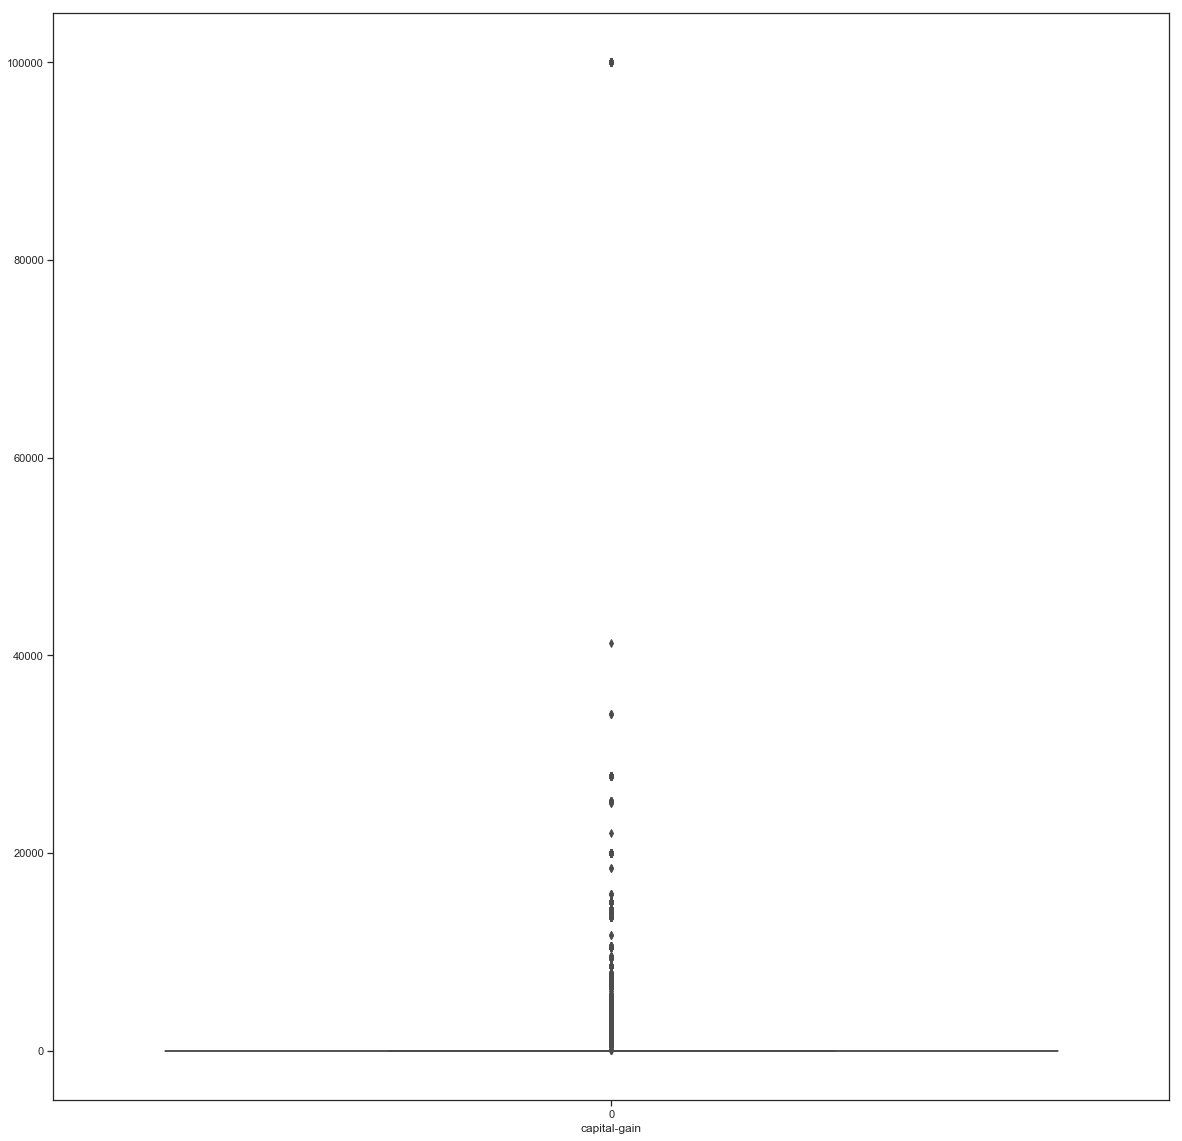

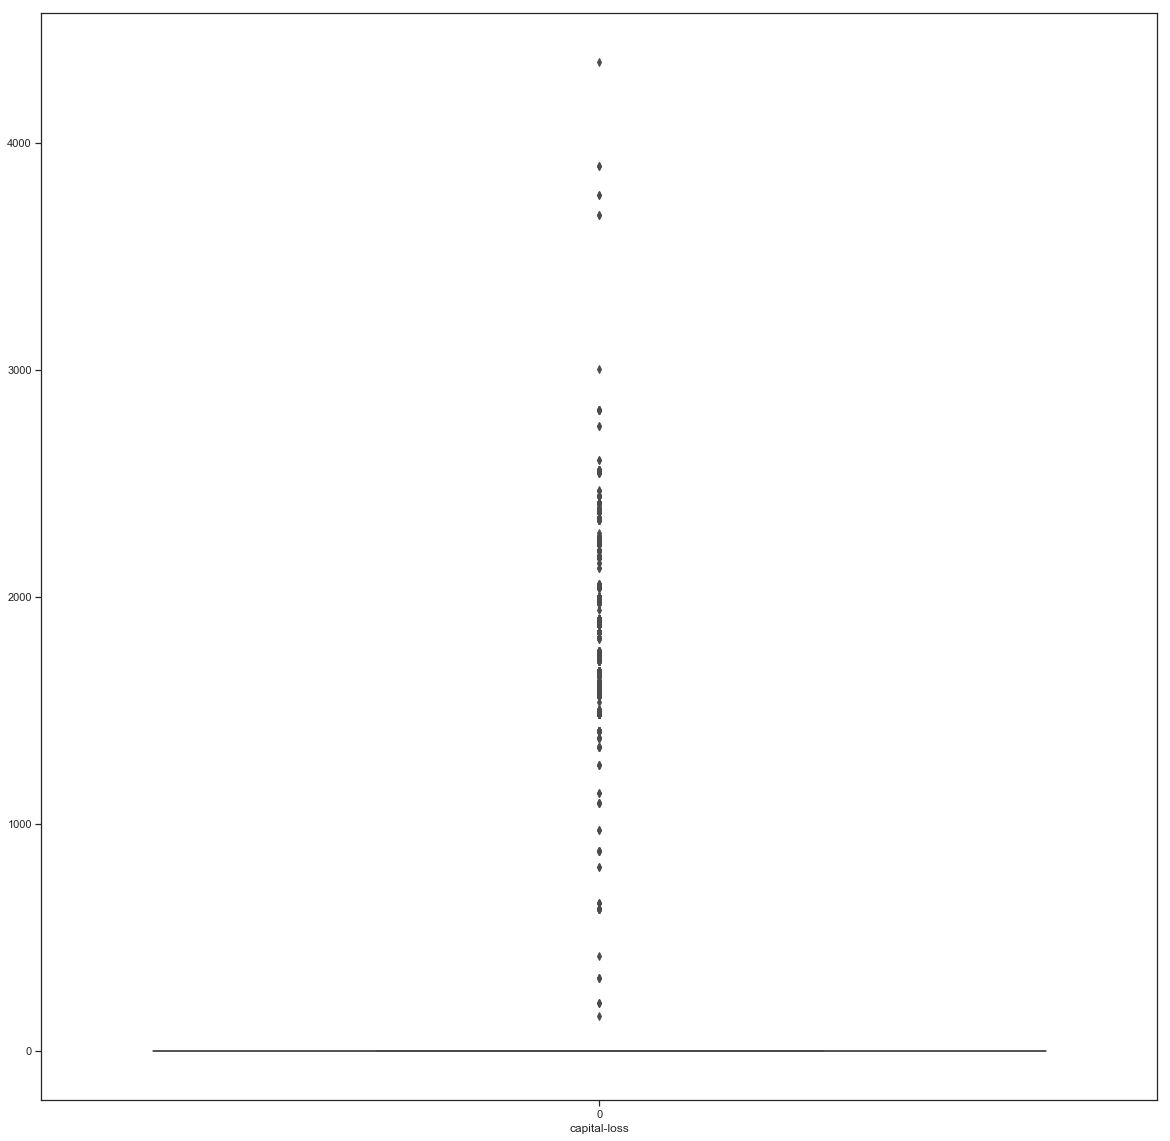

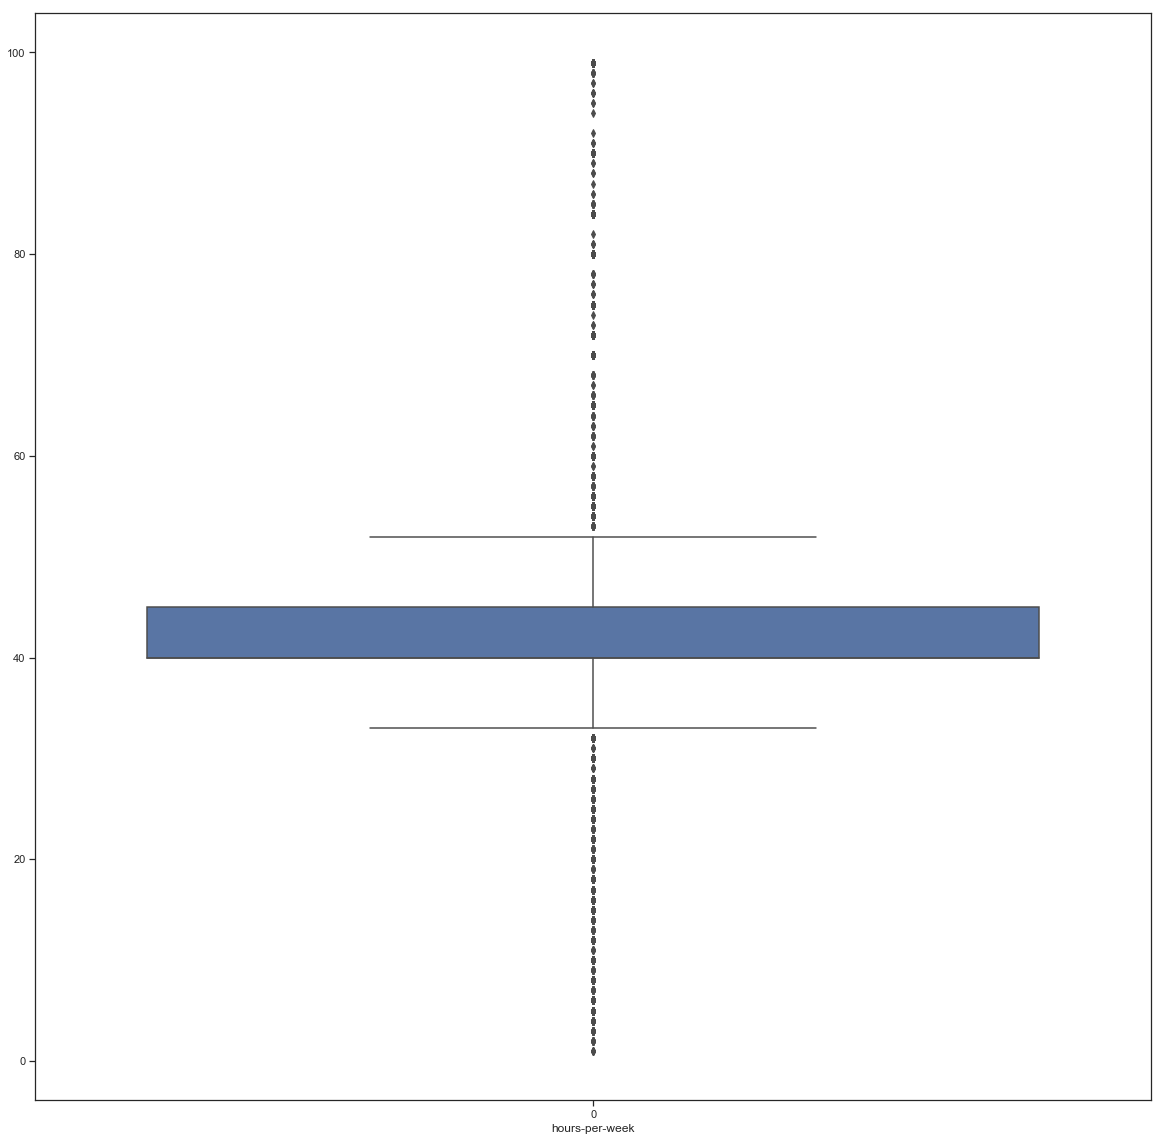

In [46]:

sns.set(style="ticks", color_codes=True)

string_columns = ['age','capital-gain',
             'capital-loss','hours-per-week']

for col in string_columns: 
    fig, ax = plt.subplots()
    ax = sns.boxplot(data=df[col]).set(
    xlabel=col
)


### One hot encode

In [13]:
new_df = df[['age','fnlwgt','education-num','capital-gain',
             'capital-loss','hours-per-week']]  #non-categorical features (some are not important)
one_hot_cols = ['workclass', 'marital-status',
                'occupation','relationship','race']  #categorical features we care about
for i in one_hot_cols:  #for every categorical feature, onehot encode it
    new_df = new_df.join(pd.get_dummies(df[i],prefix = i))
    
new_df['income'] = pd.DataFrame((df['income'] == '>50K').astype(int))  #if greater than 50k 1 else 0 for label

In [14]:
for i in new_df.columns: #print new columns
    print(i)

age
fnlwgt
education-num
capital-gain
capital-loss
hours-per-week
workclass_Federal-gov
workclass_Local-gov
workclass_Private
workclass_Self-emp-inc
workclass_Self-emp-not-inc
workclass_State-gov
workclass_Without-pay
marital-status_Divorced
marital-status_Married-AF-spouse
marital-status_Married-civ-spouse
marital-status_Married-spouse-absent
marital-status_Never-married
marital-status_Separated
marital-status_Widowed
occupation_Adm-clerical
occupation_Armed-Forces
occupation_Craft-repair
occupation_Exec-managerial
occupation_Farming-fishing
occupation_Handlers-cleaners
occupation_Machine-op-inspct
occupation_Other-service
occupation_Priv-house-serv
occupation_Prof-specialty
occupation_Protective-serv
occupation_Sales
occupation_Tech-support
occupation_Transport-moving
relationship_Husband
relationship_Not-in-family
relationship_Other-relative
relationship_Own-child
relationship_Unmarried
relationship_Wife
race_Amer-Indian-Eskimo
race_Asian-Pac-Islander
race_Black
race_Other
race_Whit

In [15]:
new_df.head(10)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,37,284582,14,0,0,40,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
5,52,209642,9,0,0,45,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,31,45781,14,14084,0,50,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
7,42,159449,13,5178,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
8,37,280464,10,0,0,80,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
9,23,122272,13,0,0,30,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


In [16]:
new_df.shape   #shape after all cleaning

(27504, 46)

In [17]:
new_df = new_df.reset_index()

In [18]:
new_df.columns[1:46]

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'rela

### Permutate/Shuffle the dataframe before applying algorithms

In [19]:
new_df = new_df.reindex(np.random.permutation(new_df.index))
new_df.head(10)

,index,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
20153,20153,32,262153,9,0,0,35,0,0,1,...,0,0,1,0,0,0,0,0,1,0
21621,21621,58,206532,9,0,0,50,0,0,1,...,0,0,0,0,0,0,0,0,1,0
6618,6618,25,34803,13,0,0,20,0,0,1,...,0,1,0,0,0,0,0,0,1,0
17157,17157,33,303867,10,0,0,50,0,0,1,...,0,0,0,0,0,0,0,0,1,0
17411,17411,27,153546,13,0,0,40,0,0,0,...,0,1,0,0,0,0,0,0,1,0
7797,7797,36,95336,9,0,0,45,0,0,1,...,0,0,0,0,0,0,0,0,1,1
14236,14236,37,245053,10,0,1504,40,0,0,1,...,0,1,0,0,0,0,0,0,1,0
3203,3203,29,175262,14,0,0,35,0,1,0,...,1,0,0,0,0,0,0,0,1,0
17545,17545,55,190514,4,0,0,75,0,0,1,...,0,0,0,0,0,0,0,0,1,0
11949,11949,38,58108,13,0,0,50,0,0,1,...,0,0,0,0,0,0,0,0,1,1


### Drop final weight (we don't need it)

In [20]:
new_df.drop(columns = ['fnlwgt'],inplace = True)
new_df.head(10)

,index,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
20153,20153,32,9,0,0,35,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
21621,21621,58,9,0,0,50,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
6618,6618,25,13,0,0,20,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
17157,17157,33,10,0,0,50,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
17411,17411,27,13,0,0,40,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
7797,7797,36,9,0,0,45,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
14236,14236,37,10,0,1504,40,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
3203,3203,29,14,0,0,35,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
17545,17545,55,4,0,0,75,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
11949,11949,38,13,0,0,50,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1


In [21]:
# Look at the class imbalance

In [22]:
df['income'].value_counts()

<=50K    20509
>50K      6995
Name: income, dtype: int64

### Get indexes for each individual feature and their respective names

In [23]:
ranges = [[1,2],[2,3],[3,4],[4,5],[5,6],[6,13],[13,20],[20,34],[34,40],[40,45],[1,45]]
columns = ['Age', 'Education','Capital Gain','Capital Loss','Hours Per Week',
           'Workclass','Marital Status','Occupation','Relationship','Race' ,'All Columns']

### Function to return results for each classifier

In [24]:
def return_results(clf,string,is_svm,is_dummy,i):
    print('---------- Results Summary for',string,'for the column:',columns[i],'----------')
    print()
    X = sc.fit_transform(new_df.iloc[:,ranges[i][0]:ranges[i][1]])  #apply standard scaler
    
    X_train = X[:num_training]   #training features 80% of data
    X_test = X[num_training:]    #testing features 20% of data
    Y_train = Y[:num_training]   #training labels 80% of data
    Y_test = Y[num_training:]   #testing labels 20% of data
    start_time = time.time()  #start counting time
    clf.fit(X_train, Y_train) #train algorithm
    scores = 0
    if is_svm == True:  #if it is an svm we do cross validation
        scores = cross_val_score(clf, X_test, Y_test, cv=5)  #5 cross validation folds for accuracy
        scores = max(scores)
    elif is_dummy == True:   #if it is dummy we calculate accuracy differently
        X_trainc, Y_trainc = \
                         check_X_y(X=X_train, y=Y_train)
        clf.fit(X=X_trainc, y=Y_trainc)
        scores = clf.score(X_test,Y_test)
                
    else:
        scores = clf.score(X_test,Y_test) #otherwise use default function
        
    print(str(time.time() - start_time)+" seconds for ", string, " to train") #end time counting and print
    print('Using' ,columns[i],'as a predictor for ' ,string,
          ' we get train accuracy of: ',clf.score(X_train,Y_train))  # train accuracy
    print('Using' ,columns[i],'as a predictor for ' ,string,
          ' we get test accuracy of: ',scores)  # calculate accuracy using 20%
    print()

    duration = time.time() - start_time

    #confusion matrix
    cf_matrix = pd.DataFrame(confusion_matrix(Y_test, clf.predict(X_test)),index = ["True <50k", "True >50k"],
                columns = ["Pred <50k", "Pred >50k"])
    print('Confusion Matrix: ')
    print(cf_matrix)
    print()
    
    #f1 score
    score_f1 = f1_score(Y_test, clf.predict(X_test))
    print('F1-score is:',score_f1)

    #plot ROC
    fpr, tpr, thr = metrics.roc_curve(Y_test, clf.predict(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic Curve for ' + str(string))
    plt.plot(fpr, tpr)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print()
    
    return [scores, clf.score(X_train,Y_train), score_f1, duration]

### Classifiers we will use with different initializations

In [33]:
#classifiers we will use with different initializations
classifiers = [SVC(kernel = 'linear',gamma ='auto',random_state = 50)]
classifiers.append(SVC(kernel = 'linear',gamma ='auto',random_state = 50,class_weight = 'balanced'))
classifiers.append(MLPClassifier(activation = 'relu',solver='lbfgs', alpha=10,hidden_layer_sizes=(4, 2)))
classifiers.append(MLPClassifier(activation = 'logistic',solver='lbfgs', alpha=10,hidden_layer_sizes=(4, 2)))
classifiers.append(MLPClassifier(activation = 'tanh',solver='lbfgs', alpha=10,hidden_layer_sizes=(4, 2)))
classifiers.append(DummyClassifier(strategy="most_frequent")) #“most_frequent”: always predicts the most 
##frequent label in the training set.

### Name of the Classifiers

In [26]:
names = ['SVM with Linear Kernel','SVM with Linear Kernel and balanced class weight',
         'Neural Network with ReLU activation',
         'Neural Network with Logistic Sigmoid activation',
         'Neural Network with tanh activation', 'Dummy Classifier that predicts most frequent label']

### Calculate accuracy per each feature

--------------- Returning Algorithm Results Summary for the feature: Age ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Age ----------

8.846881866455078 seconds for  SVM with Linear Kernel  to train
Using Age as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7458073899013771
Using Age as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7454545454545455

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


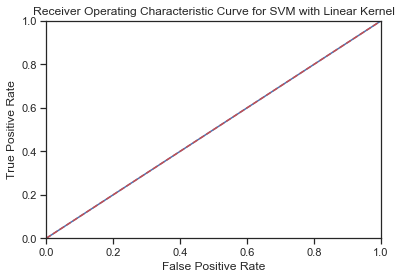


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Age ----------

19.539108991622925 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Age as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6234604372131073
Using Age as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6251137397634213

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2486       1613
True >50k        476        926

F1-score is: 0.46993148946967767


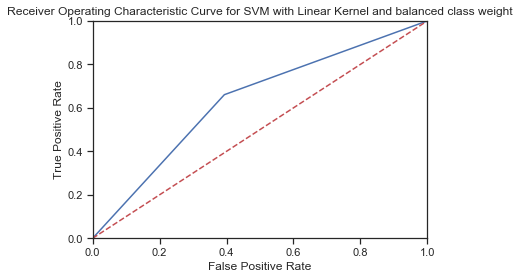


---------- Results Summary for Neural Network with ReLU activation for the column: Age ----------

0.9947383403778076 seconds for  Neural Network with ReLU activation  to train
Using Age as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7458073899013771
Using Age as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


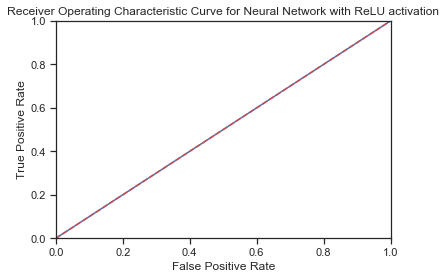


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Age ----------

0.3950624465942383 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7458073899013771
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


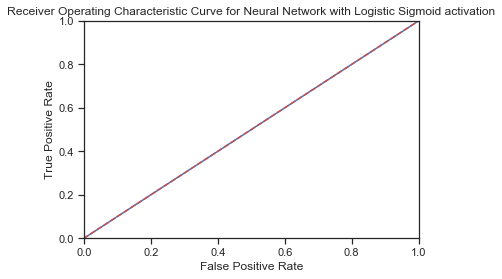


---------- Results Summary for Neural Network with tanh activation for the column: Age ----------

0.9355804920196533 seconds for  Neural Network with tanh activation  to train
Using Age as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7458073899013771
Using Age as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


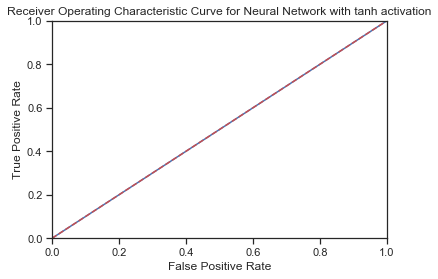


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Age ----------

0.005982875823974609 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Age as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7458073899013771
Using Age as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


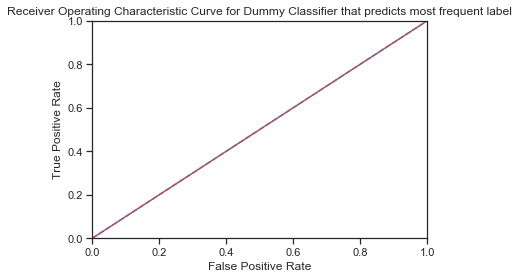


--------------- Returning Algorithm Results Summary for the feature: Education ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Education ----------

10.862797021865845 seconds for  SVM with Linear Kernel  to train
Using Education as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7458073899013771
Using Education as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7454545454545455

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


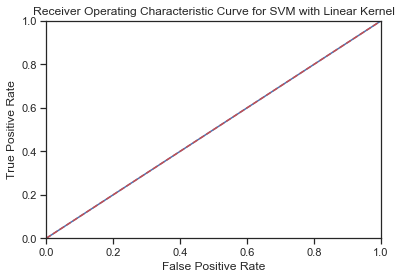


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Education ----------

18.349255561828613 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Education as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7266281870654002
Using Education as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7511353315168029

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3261        838
True >50k        643        759

F1-score is: 0.5061687229076359


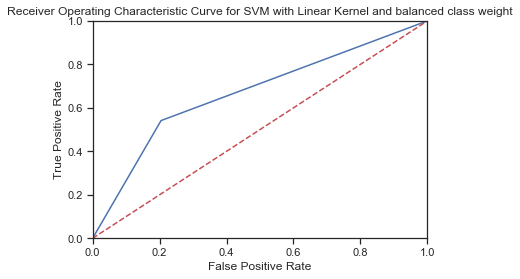


---------- Results Summary for Neural Network with ReLU activation for the column: Education ----------

1.1263470649719238 seconds for  Neural Network with ReLU activation  to train
Using Education as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7688042539653683
Using Education as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7665878931103436

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3925        174
True >50k       1110        292

F1-score is: 0.31263383297644537


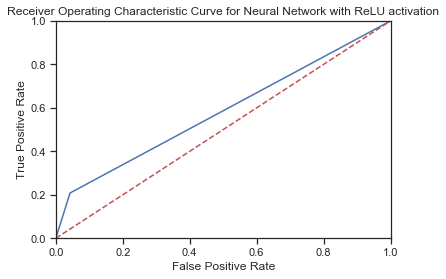


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Education ----------

0.6116452217102051 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7688042539653683
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7665878931103436

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3925        174
True >50k       1110        292

F1-score is: 0.31263383297644537


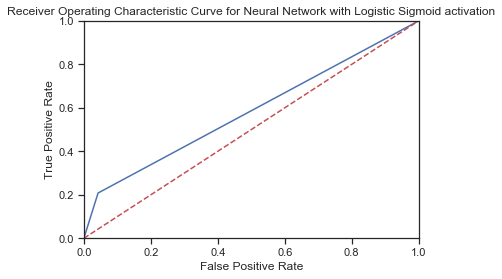


---------- Results Summary for Neural Network with tanh activation for the column: Education ----------

0.334104061126709 seconds for  Neural Network with tanh activation  to train
Using Education as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7688042539653683
Using Education as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7665878931103436

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3925        174
True >50k       1110        292

F1-score is: 0.31263383297644537


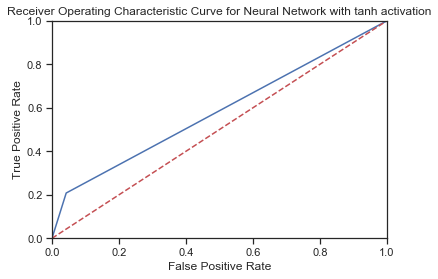


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Education ----------

0.00399017333984375 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Education as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7458073899013771
Using Education as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


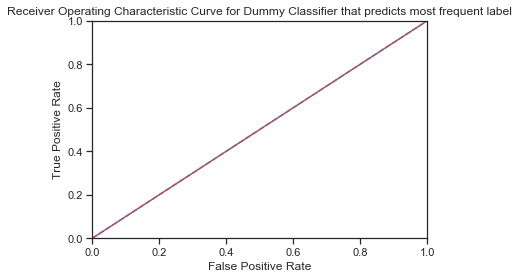


--------------- Returning Algorithm Results Summary for the feature: Capital Gain ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Capital Gain ----------

4.4845969676971436 seconds for  SVM with Linear Kernel  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7848020724446666
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7920072661217076

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4038         61
True >50k       1109        293

F1-score is: 0.3337129840546697


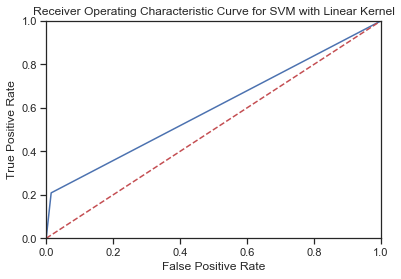


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Capital Gain ----------

10.617084503173828 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7785302004272144
Using Capital Gain as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7910990009082652

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3982        117
True >50k       1095        307

F1-score is: 0.3362541073384447


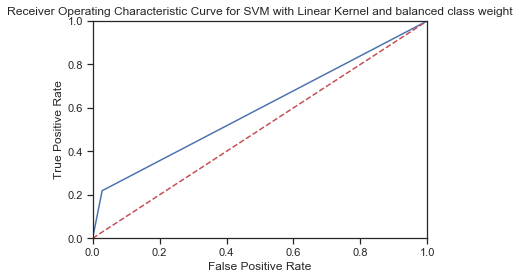


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Gain ----------

0.7171158790588379 seconds for  Neural Network with ReLU activation  to train
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7887106303685861
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7924013815669878

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4075         24
True >50k       1118        284

F1-score is: 0.33216374269005844


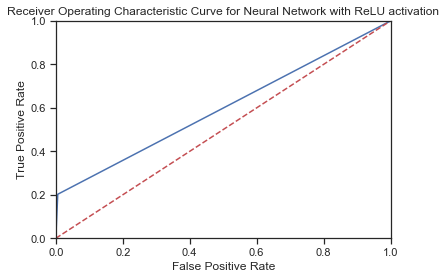


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Gain ----------

0.9176685810089111 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7879380084533927
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7916742410470824

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4075         24
True >50k       1122        280

F1-score is: 0.328253223915592


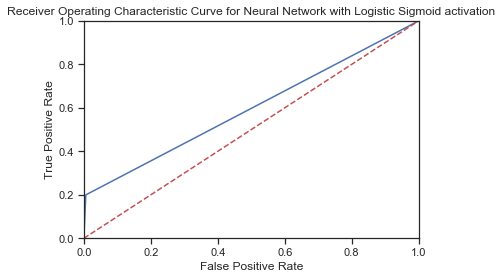


---------- Results Summary for Neural Network with tanh activation for the column: Capital Gain ----------

0.17229127883911133 seconds for  Neural Network with tanh activation  to train
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7877107667136299
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7904017451372478

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4087         12
True >50k       1141        261

F1-score is: 0.3116417910447761


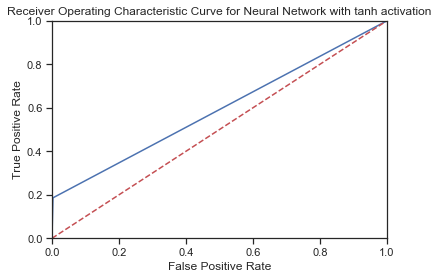


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Capital Gain ----------

0.004986286163330078 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7458073899013771
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


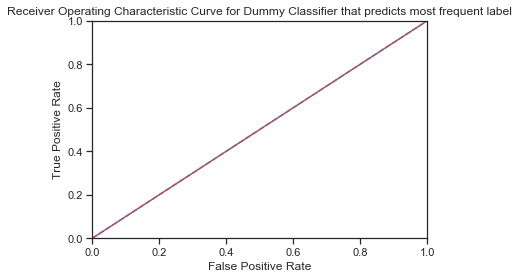


--------------- Returning Algorithm Results Summary for the feature: Capital Loss ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Capital Loss ----------

4.994403123855591 seconds for  SVM with Linear Kernel  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7490342226060083
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7525022747952684

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3982        117
True >50k       1274        128

F1-score is: 0.1554341226472374


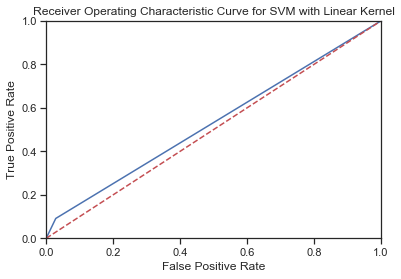


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Capital Loss ----------

11.623135328292847 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7488069808662455
Using Capital Loss as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7518181818181818

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3980        119
True >50k       1274        128

F1-score is: 0.15524560339599755


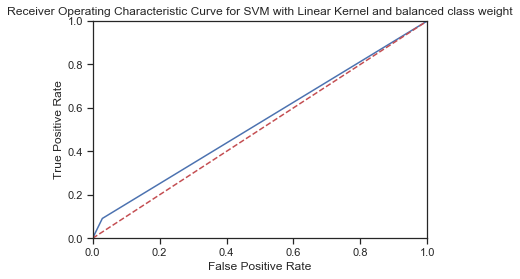


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Loss ----------

1.8587150573730469 seconds for  Neural Network with ReLU activation  to train
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7606689996818615
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7594982730412653

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4057         42
True >50k       1281        121

F1-score is: 0.1546325878594249


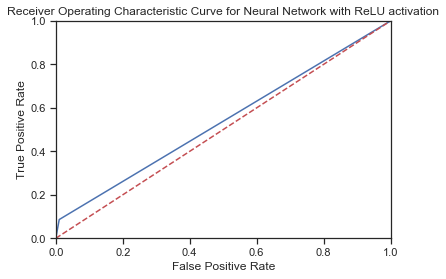


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Loss ----------

1.04160737991333 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7603508612461937
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7594982730412653

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4057         42
True >50k       1281        121

F1-score is: 0.1546325878594249


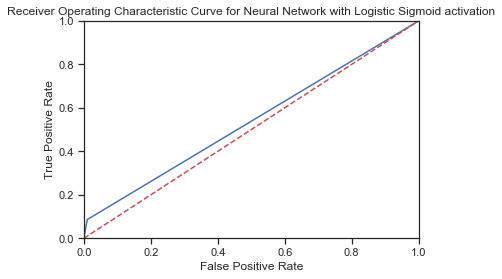


---------- Results Summary for Neural Network with tanh activation for the column: Capital Loss ----------

1.2570512294769287 seconds for  Neural Network with tanh activation  to train
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7603508612461937
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7594982730412653

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4057         42
True >50k       1281        121

F1-score is: 0.1546325878594249


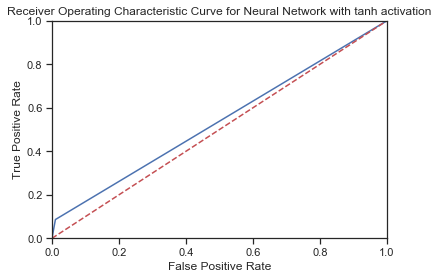


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Capital Loss ----------

0.003988742828369141 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7458073899013771
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


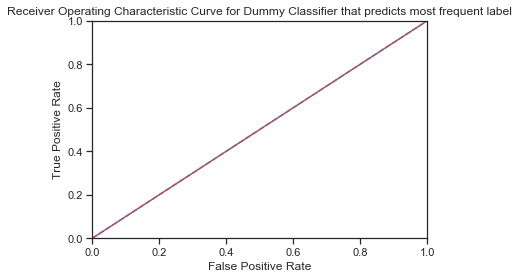


--------------- Returning Algorithm Results Summary for the feature: Hours Per Week ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Hours Per Week ----------

11.177128791809082 seconds for  SVM with Linear Kernel  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7458073899013771
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7454545454545455

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


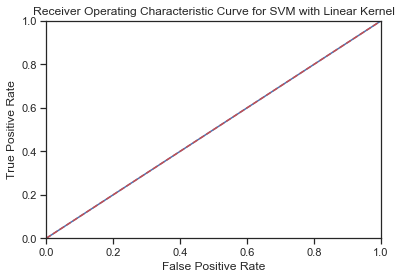


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Hours Per Week ----------

23.01765751838684 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6921328909694132
Using Hours Per Week as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7124658780709736

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3162        937
True >50k        713        689

F1-score is: 0.45508586525759576


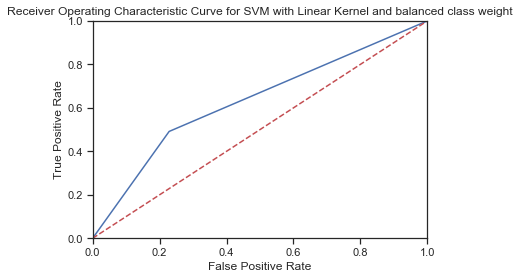


---------- Results Summary for Neural Network with ReLU activation for the column: Hours Per Week ----------

0.9543955326080322 seconds for  Neural Network with ReLU activation  to train
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7458073899013771
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


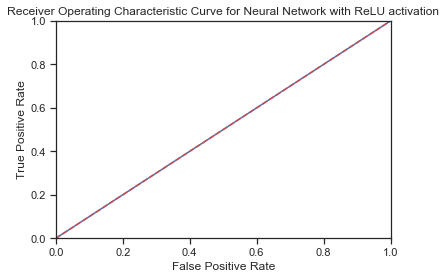


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Hours Per Week ----------

0.4857349395751953 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7458073899013771
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


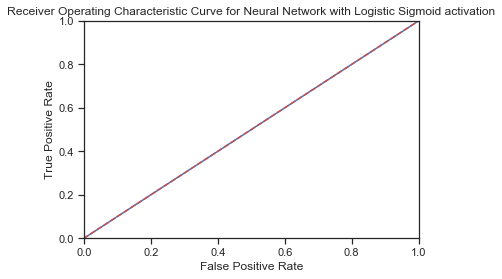


---------- Results Summary for Neural Network with tanh activation for the column: Hours Per Week ----------

0.40790700912475586 seconds for  Neural Network with tanh activation  to train
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7458073899013771
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


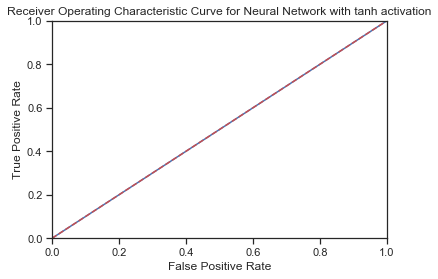


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Hours Per Week ----------

0.008177042007446289 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7458073899013771
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


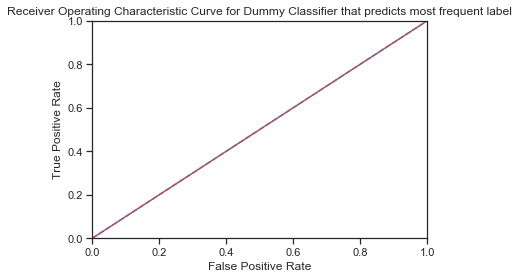


--------------- Returning Algorithm Results Summary for the feature: Workclass ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Workclass ----------

10.132616758346558 seconds for  SVM with Linear Kernel  to train
Using Workclass as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7504885697404899
Using Workclass as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7625113739763422

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4016         83
True >50k       1297        105

F1-score is: 0.13207547169811323


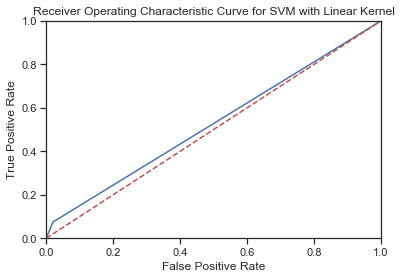


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Workclass ----------

20.142333507537842 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Workclass as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6559105576512294
Using Workclass as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6751592356687898

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3150        949
True >50k        923        479

F1-score is: 0.3385159010600707


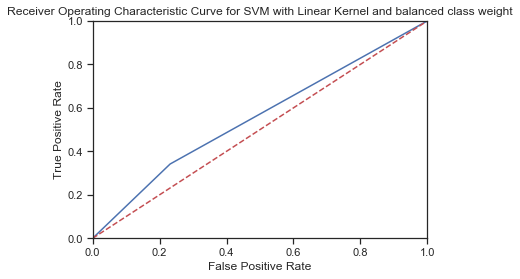


---------- Results Summary for Neural Network with ReLU activation for the column: Workclass ----------

1.0442149639129639 seconds for  Neural Network with ReLU activation  to train
Using Workclass as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7504885697404899
Using Workclass as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7491365206326123

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4016         83
True >50k       1297        105

F1-score is: 0.13207547169811323


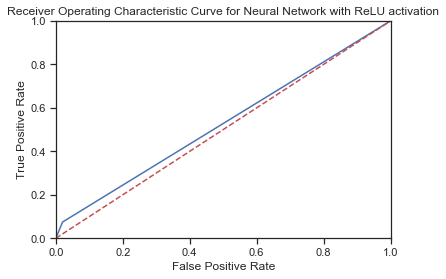


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Workclass ----------

1.0448601245880127 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7504885697404899
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7491365206326123

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4016         83
True >50k       1297        105

F1-score is: 0.13207547169811323


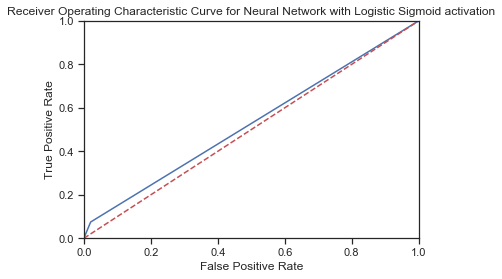


---------- Results Summary for Neural Network with tanh activation for the column: Workclass ----------

0.6695301532745361 seconds for  Neural Network with tanh activation  to train
Using Workclass as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7504885697404899
Using Workclass as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7491365206326123

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4016         83
True >50k       1297        105

F1-score is: 0.13207547169811323


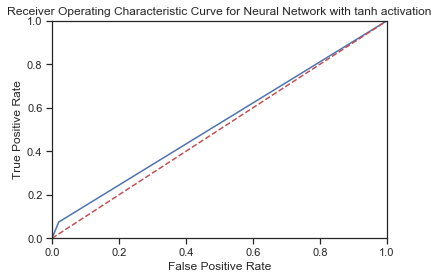


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Workclass ----------

0.003989458084106445 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7458073899013771
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


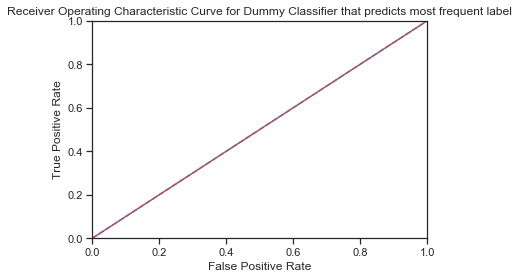


--------------- Returning Algorithm Results Summary for the feature: Marital Status ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Marital Status ----------

11.798796653747559 seconds for  SVM with Linear Kernel  to train
Using Marital Status as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7458073899013771
Using Marital Status as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7454545454545455

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


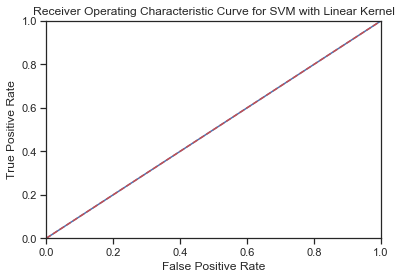


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Marital Status ----------

13.100709676742554 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Marital Status as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7126300958960142
Using Marital Status as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7381818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2753       1346
True >50k        207       1195

F1-score is: 0.6061374587877251


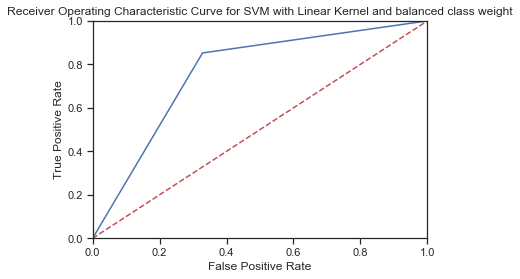


---------- Results Summary for Neural Network with ReLU activation for the column: Marital Status ----------

0.2771916389465332 seconds for  Neural Network with ReLU activation  to train
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7458073899013771
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


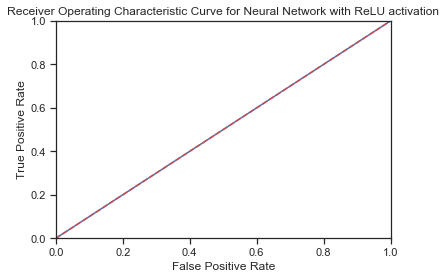


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Marital Status ----------

1.1017251014709473 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7458073899013771
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


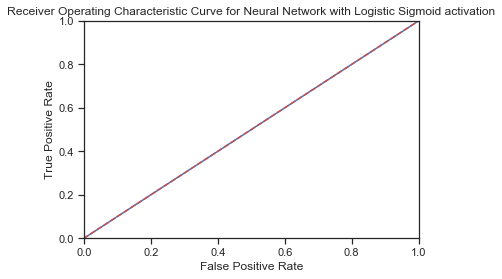


---------- Results Summary for Neural Network with tanh activation for the column: Marital Status ----------

0.7138617038726807 seconds for  Neural Network with tanh activation  to train
Using Marital Status as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7458073899013771
Using Marital Status as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7449554626431558

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4096          3
True >50k       1400          2

F1-score is: 0.0028429282160625444


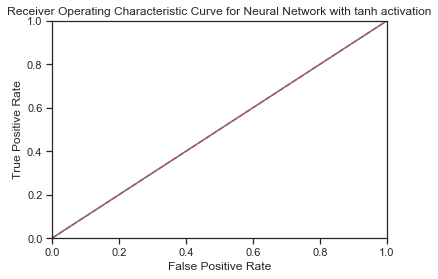


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Marital Status ----------

0.00698399543762207 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7458073899013771
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


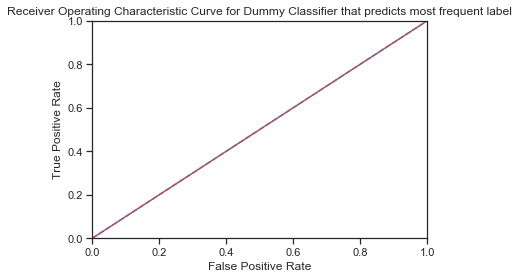


--------------- Returning Algorithm Results Summary for the feature: Occupation ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Occupation ----------

18.195619583129883 seconds for  SVM with Linear Kernel  to train
Using Occupation as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7458073899013771
Using Occupation as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7515923566878981

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


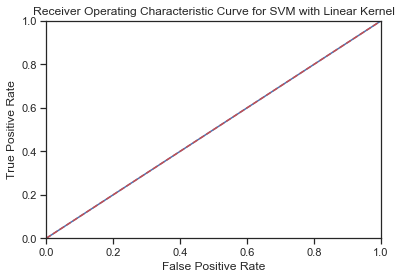


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Occupation ----------

27.175219774246216 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Occupation as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6516384129436895
Using Occupation as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7070063694267515

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2638       1461
True >50k        405        997

F1-score is: 0.5165803108808291


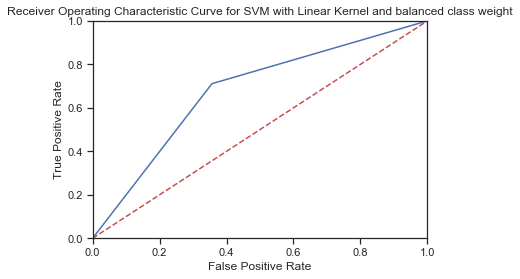


---------- Results Summary for Neural Network with ReLU activation for the column: Occupation ----------

1.6224992275238037 seconds for  Neural Network with ReLU activation  to train
Using Occupation as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7458073899013771
Using Occupation as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


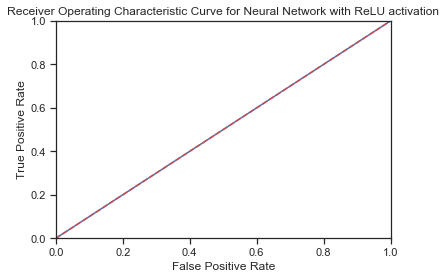


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Occupation ----------

0.8986215591430664 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7458073899013771
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


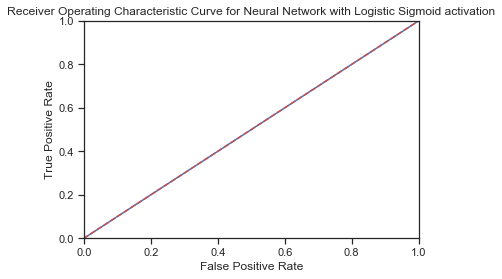


---------- Results Summary for Neural Network with tanh activation for the column: Occupation ----------

1.2886738777160645 seconds for  Neural Network with tanh activation  to train
Using Occupation as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7458073899013771
Using Occupation as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


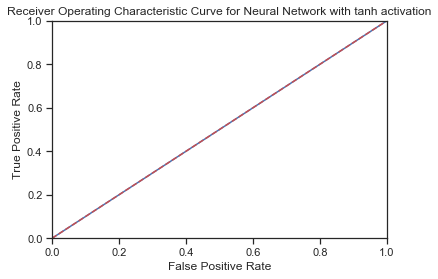


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Occupation ----------

0.003988504409790039 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7458073899013771
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


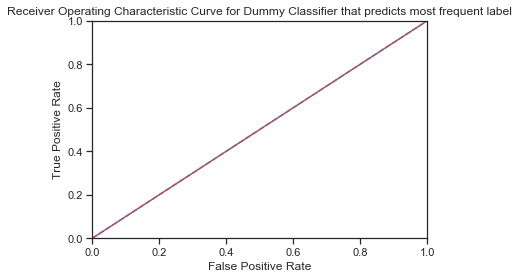


--------------- Returning Algorithm Results Summary for the feature: Relationship ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Relationship ----------

12.649440288543701 seconds for  SVM with Linear Kernel  to train
Using Relationship as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7472162886879062
Using Relationship as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7454545454545455

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3968        131
True >50k       1283        119

F1-score is: 0.1440677966101695


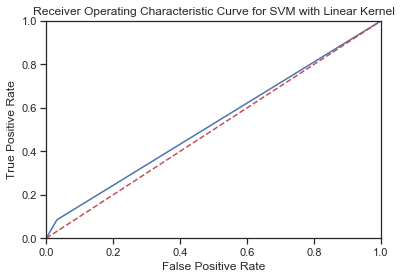


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Relationship ----------

13.323445081710815 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Relationship as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7161296186883607
Using Relationship as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.740909090909091

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2775       1324
True >50k        211       1191

F1-score is: 0.6081184580035741


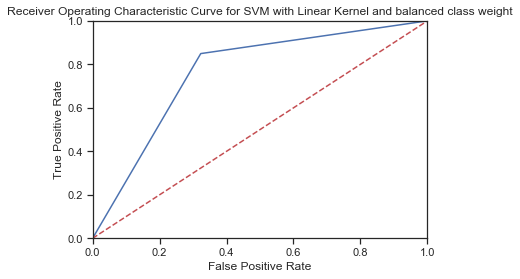


---------- Results Summary for Neural Network with ReLU activation for the column: Relationship ----------

0.21363615989685059 seconds for  Neural Network with ReLU activation  to train
Using Relationship as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7458073899013771
Using Relationship as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


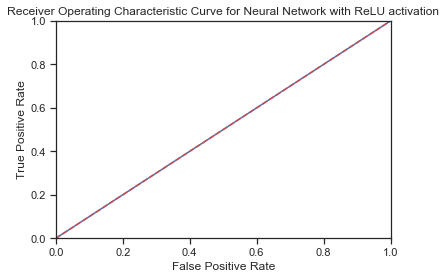


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Relationship ----------

1.4423346519470215 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7472162886879062
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7429558262134157

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3968        131
True >50k       1283        119

F1-score is: 0.1440677966101695


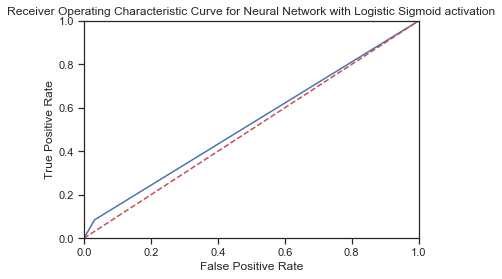


---------- Results Summary for Neural Network with tanh activation for the column: Relationship ----------

1.8030433654785156 seconds for  Neural Network with tanh activation  to train
Using Relationship as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7472162886879062
Using Relationship as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7429558262134157

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3968        131
True >50k       1283        119

F1-score is: 0.1440677966101695


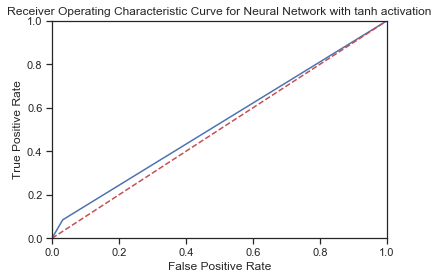


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Relationship ----------

0.00546574592590332 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7458073899013771
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


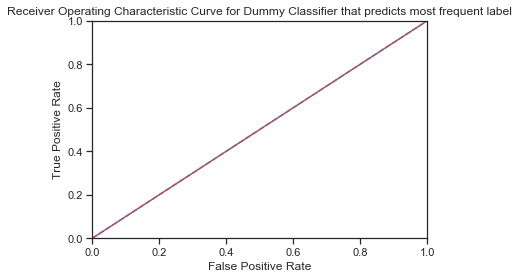


--------------- Returning Algorithm Results Summary for the feature: Race ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Race ----------

8.662683010101318 seconds for  SVM with Linear Kernel  to train
Using Race as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7458073899013771
Using Race as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7454545454545455

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


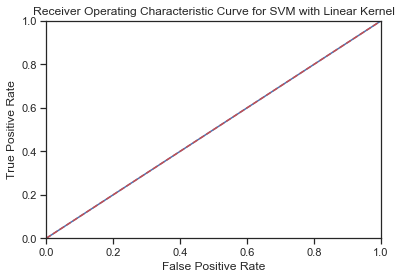


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Race ----------

16.205220699310303 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Race as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.34063536790437665
Using Race as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.3475887170154686

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k        569       3530
True >50k         97       1305

F1-score is: 0.41847041847041855


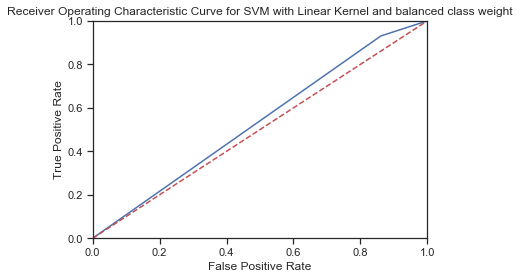


---------- Results Summary for Neural Network with ReLU activation for the column: Race ----------

0.4378976821899414 seconds for  Neural Network with ReLU activation  to train
Using Race as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7458073899013771
Using Race as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


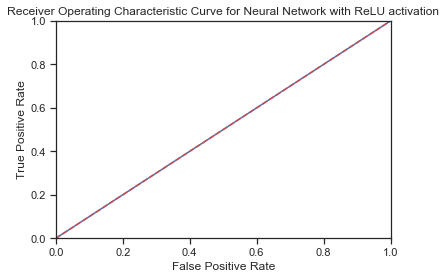


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Race ----------

0.40188145637512207 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7458073899013771
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


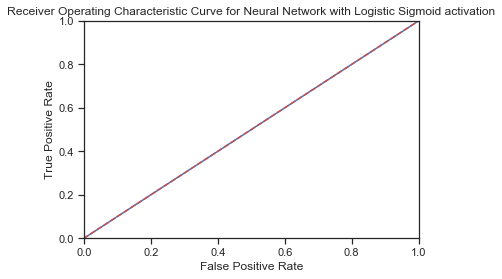


---------- Results Summary for Neural Network with tanh activation for the column: Race ----------

0.35389065742492676 seconds for  Neural Network with tanh activation  to train
Using Race as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7458073899013771
Using Race as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


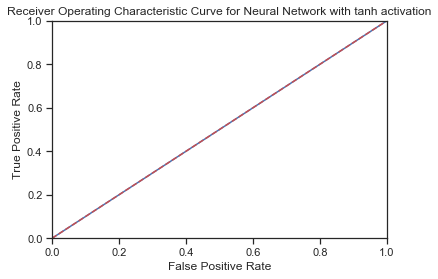


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Race ----------

0.004986763000488281 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Race as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7458073899013771
Using Race as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


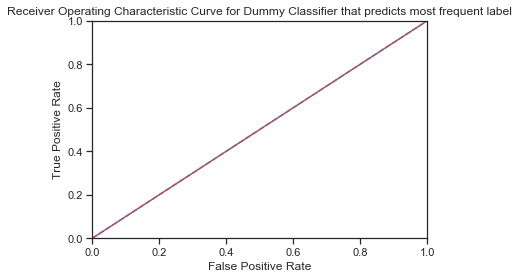


--------------- Returning Algorithm Results Summary for the feature: All Columns ---------------

---------- Results Summary for SVM with Linear Kernel for the column: All Columns ----------

61.073479413986206 seconds for  SVM with Linear Kernel  to train
Using All Columns as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.8444757533063673
Using All Columns as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.8592188919164396

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3816        283
True >50k        532        870

F1-score is: 0.6810176125244618


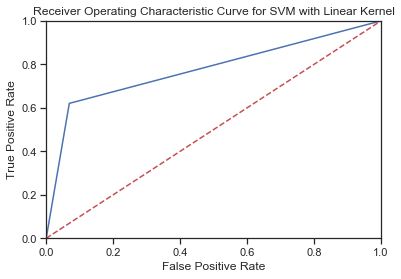


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: All Columns ----------

79.21867322921753 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using All Columns as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7900740808071627
Using All Columns as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.8072727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3145        954
True >50k        190       1212

F1-score is: 0.679372197309417


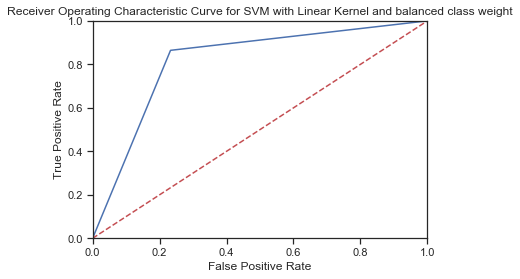


---------- Results Summary for Neural Network with ReLU activation for the column: All Columns ----------

6.580932140350342 seconds for  Neural Network with ReLU activation  to train
Using All Columns as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.8521110757623961
Using All Columns as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.8545718960189057

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3778        321
True >50k        479        923

F1-score is: 0.6976568405139832


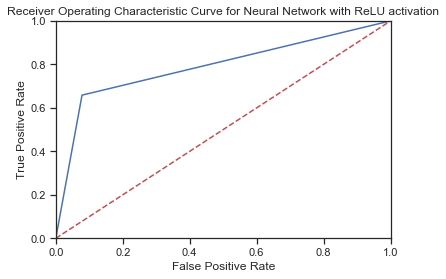


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: All Columns ----------

5.270931959152222 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.8525655592419216
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.8531176149790947

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3780        319
True >50k        489        913

F1-score is: 0.6932422171602127


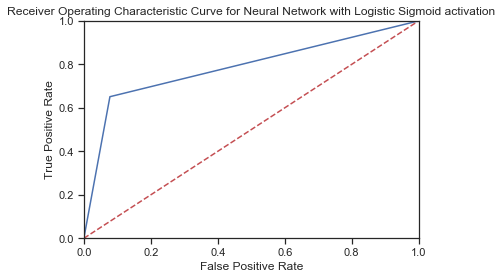


---------- Results Summary for Neural Network with tanh activation for the column: All Columns ----------

6.260833024978638 seconds for  Neural Network with tanh activation  to train
Using All Columns as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.8525655592419216
Using All Columns as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.8545718960189057

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3800        299
True >50k        501        901

F1-score is: 0.6925441967717142


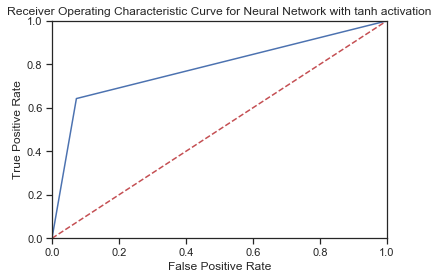


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: All Columns ----------

0.009041547775268555 seconds for  Dummy Classifier that predicts most frequent label  to train
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7458073899013771
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7451372477731322

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4099          0
True >50k       1402          0

F1-score is: 0.0


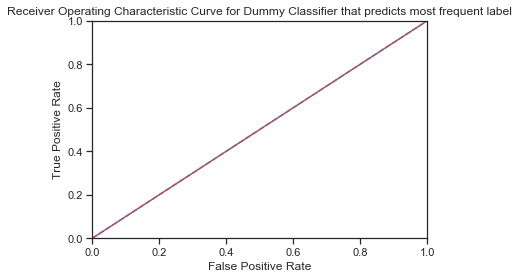

In [27]:
Y = np.array(new_df.iloc[:,45:46]) #labels
num_training = int(0.8*Y.shape[0])  #80% of the data for training
sc = StandardScaler()

# matrizes with the quality criteria
test_accuracies = np.zeros((len(ranges), len(classifiers)))
train_accuracies = np.zeros((len(ranges), len(classifiers)))
f1_scores = np.zeros((len(ranges), len(classifiers)))
duration = np.zeros((len(ranges), len(classifiers)))

for i in range(len(ranges)):
    print('--------------- Returning Algorithm Results Summary for the feature:',columns[i],'---------------')
    print()
    for j in range(len(classifiers)):
        if j == 0 or j == 1:   # if it is svm do cross validation
            test_accuracies[i,j],train_accuracies[i,j],f1_scores[i,j], duration[i,j] = return_results(classifiers[j],names[j],True,False,i)
        elif j == 5:  # if it is a dummyclassifier, calculate accuracy the proper way 
            test_accuracies[i,j],train_accuracies[i,j],f1_scores[i,j], duration[i,j] = return_results(classifiers[j],names[j],False,True,i)
        else:    # if a regular classifier, just do the normal operations
            test_accuracies[i,j],train_accuracies[i,j],f1_scores[i,j], duration[i,j] = return_results(classifiers[j],names[j],False,False,i)

In [28]:
names

['SVM with Linear Kernel',
 'SVM with Linear Kernel and balanced class weight',
 'Neural Network with ReLU activation',
 'Neural Network with Logistic Sigmoid activation',
 'Neural Network with tanh activation',
 'Dummy Classifier that predicts most frequent label']

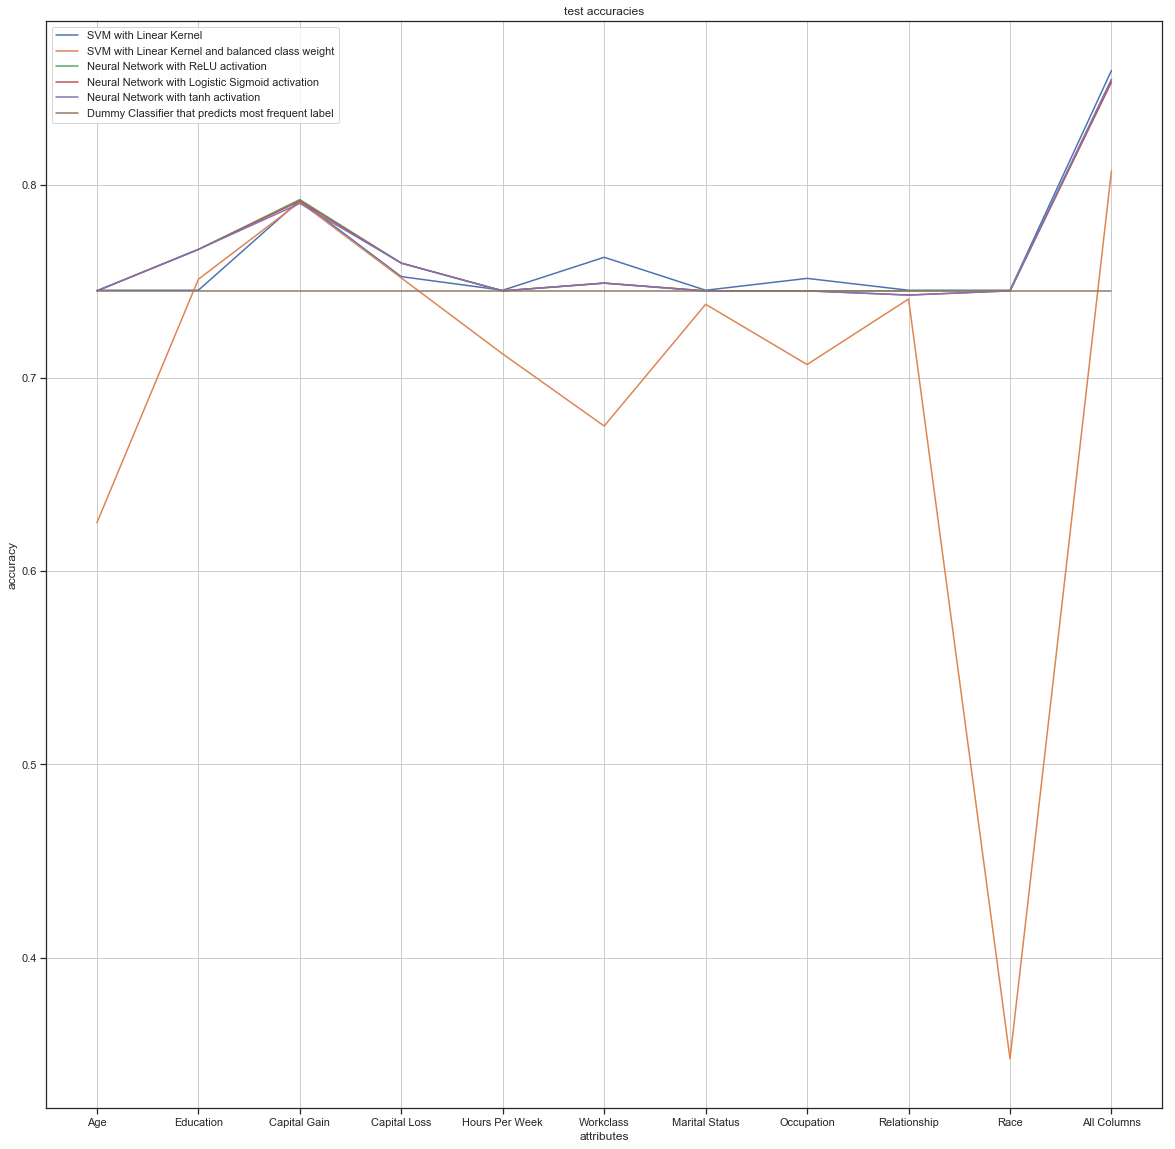

test accuracies:  [[0.74545455 0.62511374 0.74513725 0.74513725 0.74513725 0.74513725]
 [0.74545455 0.75113533 0.76658789 0.76658789 0.76658789 0.74513725]
 [0.79200727 0.791099   0.79240138 0.79167424 0.79040175 0.74513725]
 [0.75250227 0.75181818 0.75949827 0.75949827 0.75949827 0.74513725]
 [0.74545455 0.71246588 0.74513725 0.74513725 0.74513725 0.74513725]
 [0.76251137 0.67515924 0.74913652 0.74913652 0.74913652 0.74513725]
 [0.74545455 0.73818182 0.74513725 0.74513725 0.74495546 0.74513725]
 [0.75159236 0.70700637 0.74513725 0.74513725 0.74513725 0.74513725]
 [0.74545455 0.74090909 0.74513725 0.74295583 0.74295583 0.74513725]
 [0.74545455 0.34758872 0.74513725 0.74513725 0.74513725 0.74513725]
 [0.85921889 0.80727273 0.8545719  0.85311761 0.8545719  0.74513725]]


In [29]:
## Visualizing test accuracy

test_accuracies_svm_LK = test_accuracies[:,0]
test_accuracies_svm_LK_cw = test_accuracies[:,1]
test_accuracies_NN_ReLU = test_accuracies[:,2]
test_accuracies_NN_LSa = test_accuracies[:,3]
test_accuracies_NN_tanh = test_accuracies[:,4]
test_accuracies_DCLF = test_accuracies[:,5]


plt.rcParams["figure.figsize"] = (20,20)

fig, ax = plt.subplots()
ax.plot(columns, test_accuracies_svm_LK, label= names[0])
ax.plot(columns, test_accuracies_svm_LK_cw, label = names[1])
ax.plot(columns, test_accuracies_NN_ReLU, label = names[2])
ax.plot(columns, test_accuracies_NN_LSa, label = names[3])
ax.plot(columns, test_accuracies_NN_tanh, label = names[4])
ax.plot(columns, test_accuracies_DCLF, label = names[5])


ax.set(xlabel='attributes', ylabel='accuracy',
       title='test accuracies')
ax.grid()
plt.legend()

fig.savefig("test_accuracies.png")

plt.show()

print('test accuracies: ',
     test_accuracies)

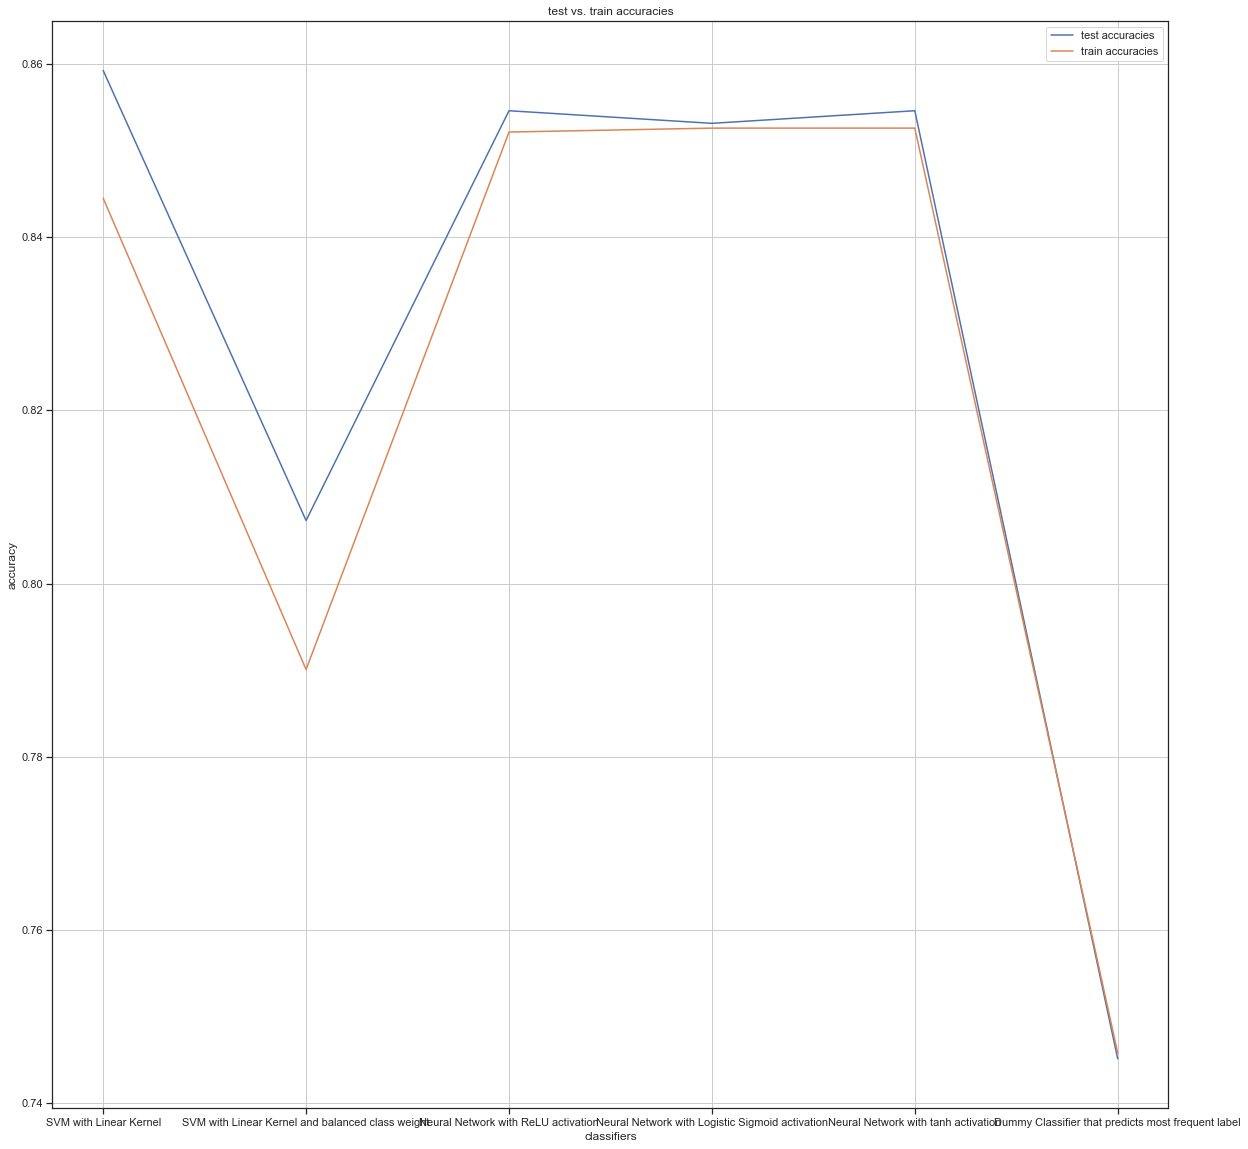

train accuracies for all variables:  [0.85921889 0.80727273 0.8545719  0.85311761 0.8545719  0.74513725]
testaccuracies for all variables:  [0.84447575 0.79007408 0.85211108 0.85256556 0.85256556 0.74580739]


In [30]:
# visualizing test versus train accuracy

plt.rcParams["figure.figsize"] = (20,20)

test_acc_all_var = test_accuracies[-1,:]
train_acc_all_var = train_accuracies[-1,:]

fig, ax = plt.subplots()
ax.plot(names, test_acc_all_var, label= 'test accuracies')
ax.plot(names, train_acc_all_var, label= 'train accuracies')



ax.set(xlabel='classifiers', ylabel='accuracy',
       title='test vs. train accuracies')
ax.grid()
plt.legend()

fig.savefig("test_vs_train_accuracies.png")

plt.show()

print('train accuracies for all variables: ', 
      test_acc_all_var)
print('testaccuracies for all variables: ', 
      train_acc_all_var)

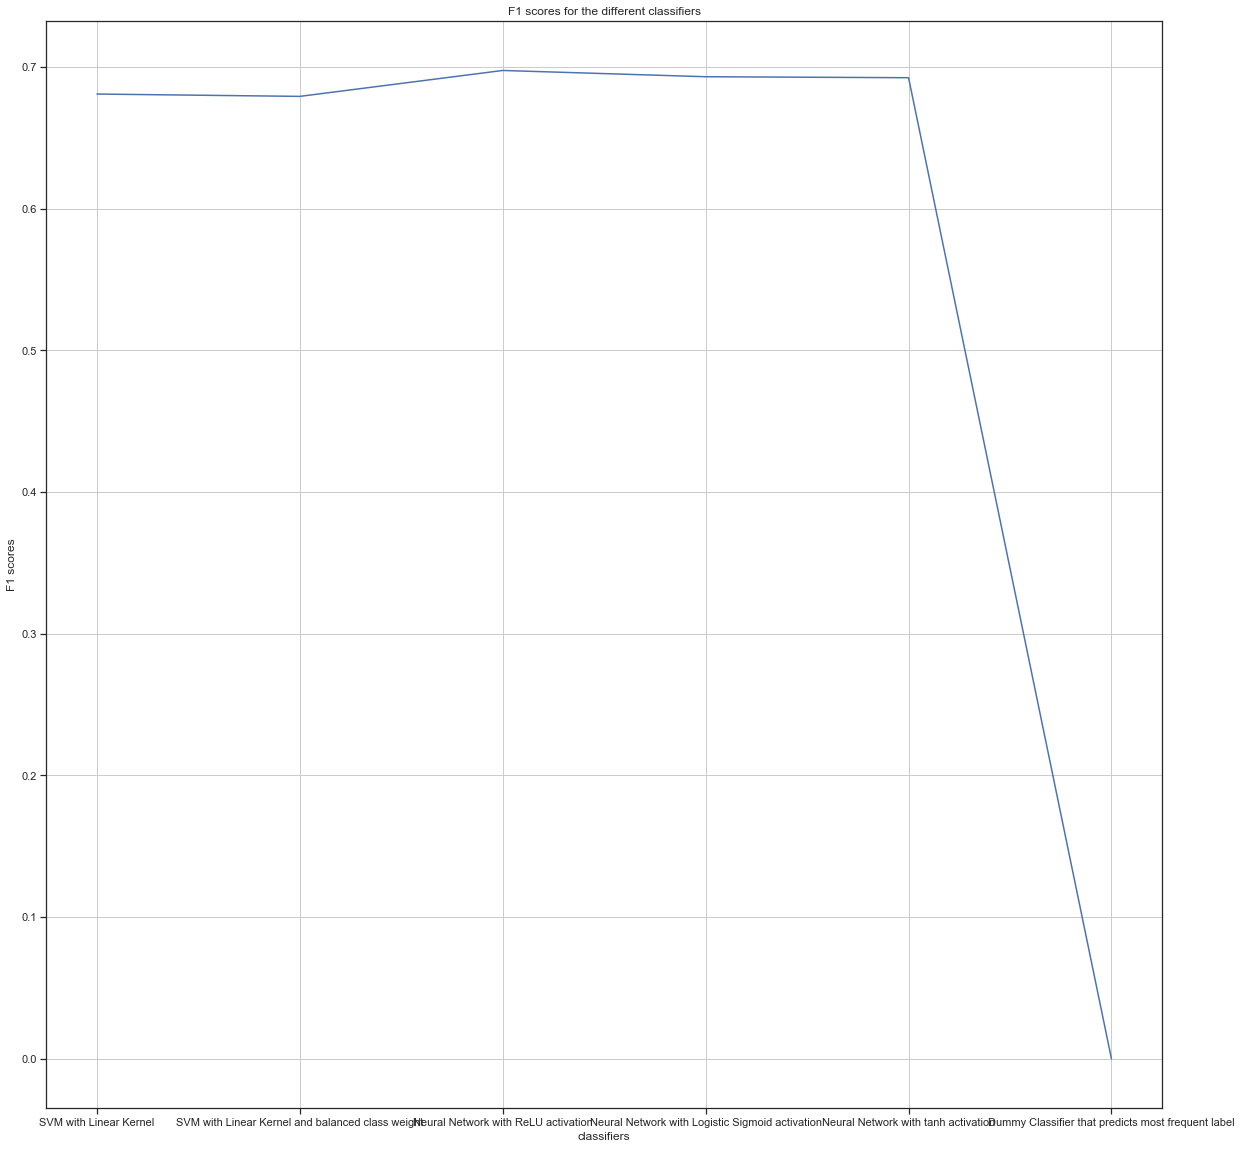

[0.68101761 0.6793722  0.69765684 0.69324222 0.6925442  0.        ]


In [31]:
# plot F1 scores

plt.rcParams["figure.figsize"] = (20,20)

fig, ax = plt.subplots()
ax.plot(names, f1_scores[-1,:])


ax.set(xlabel='classifiers', ylabel='F1 scores',
       title='F1 scores for the different classifiers')
ax.grid()

fig.savefig("F1_scores.png")

plt.show()

print(f1_scores[-1,:])

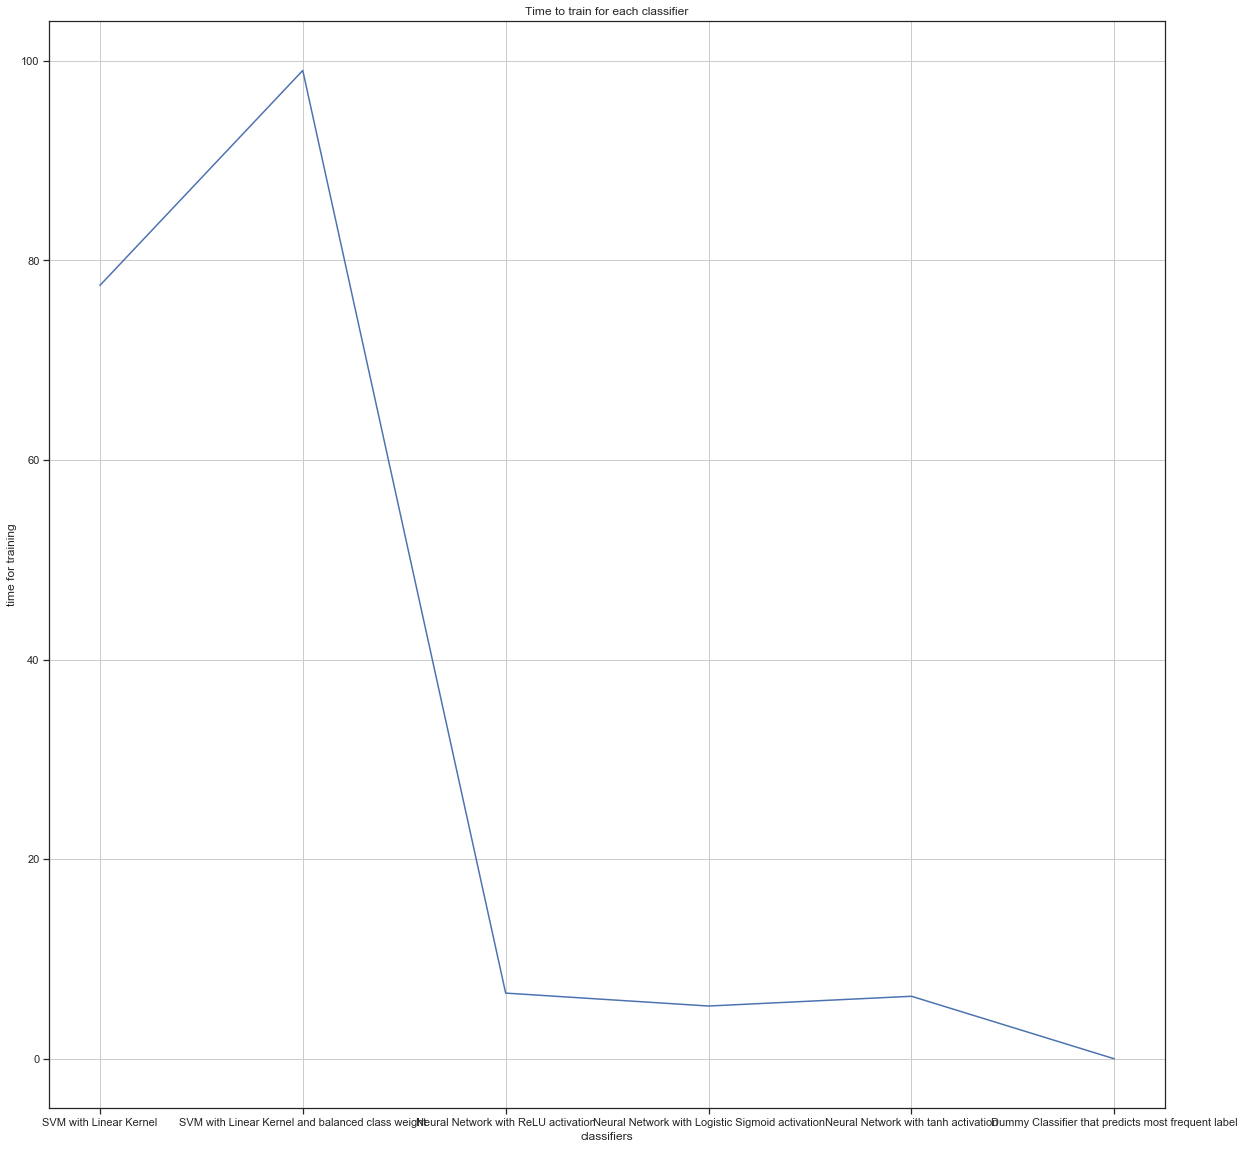

[7.74855297e+01 9.90244837e+01 6.59988046e+00 5.30480528e+00
 6.28140402e+00 1.45909786e-02]


In [32]:
# visualizing how long the classifier takes to train

plt.rcParams["figure.figsize"] = (20,20)

fig, ax = plt.subplots()
ax.plot(names, duration[-1,:])


ax.set(xlabel='classifiers', ylabel='time for training',
       title='Time to train for each classifier')
ax.grid()

fig.savefig("training_time.png")

plt.show()

print(duration[-1,:])